In [3]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 11

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [4]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row (Original Image: Ground Truth : Predicted)
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        if name == "original_image":
          #print(image.shape)
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
        else:
          #print(image.shape)
          # get title from the parameter names
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
    plt.show()

#Function to reverse one-hot-encode an image
def reverse_one_hot(image):
    #argmax to return the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [18]:
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

SIZEX = 128
SIZEY = 128

rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
    self.masks_fps = [os.path.join(masks_dir, mask_id.replace("jpg","png")) for mask_id in self.image_ids]
    self.coords_fps = [os.path.join(coords_dir, coords_id.replace("jpg", "txt")) for coords_id in self.image_ids]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    #plt.imshow(mask)
    #plt.show
    #plt.imshow(image)

    # crop to center face
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    with open(self.coords_fps[i], 'rb') as f:

      contents = str(f.read()).split("\\n")
      contents = [[int(float(single.replace("\\r", "").
                             replace("'", "").replace("b", "").replace("\\x1a", "")
                             )) for single in pair.split(" ")] for pair in contents[2:-2]]
      try:
        
        #print(contents)

        contents = np.array(contents)
        for pair in contents:
          #plt.scatter((pair[0]), (pair[1]), color="red")

          if (pair[0]) < smallest_x:
            smallest_x = (pair[0])
          
          if (pair[0]) > biggest_x:
            biggest_x = (pair[0])

          if (pair[1]) < smallest_y:
            smallest_y = (pair[1])
          
          if (pair[1]) > biggest_y:
            biggest_y = (pair[1])


        crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

        image = image[smallest_y: biggest_y, smallest_x:biggest_x]
        mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]


        mask = cv2.resize(mask, (SIZEY, SIZEY))
        image = cv2.resize(image, (SIZEY, SIZEY))
        mask = np.expand_dims(mask,2)
      except:
        #item corrutpted
        return self.__getitem__(i-1)
    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).permute(0,3,1,2).float()

    return (image, one_hot_Y.squeeze(0))


train_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/labels"
train_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/landmarks"

val_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/images"
val_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/labels"
val_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/landmarks"

test_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/images"
test_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/labels"
test_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/landmarks"

train_ds = MyDataSet(train_x_path, train_y_path, train_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation())
val_ds = MyDataSet(val_x_path, val_y_path, val_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())
test_ds = MyDataSet(test_x_path, test_y_path, test_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())

/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


0 : (3, 128, 128) torch.Size([11, 128, 128])


/tmp/ipykernel_15278/2924039091.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


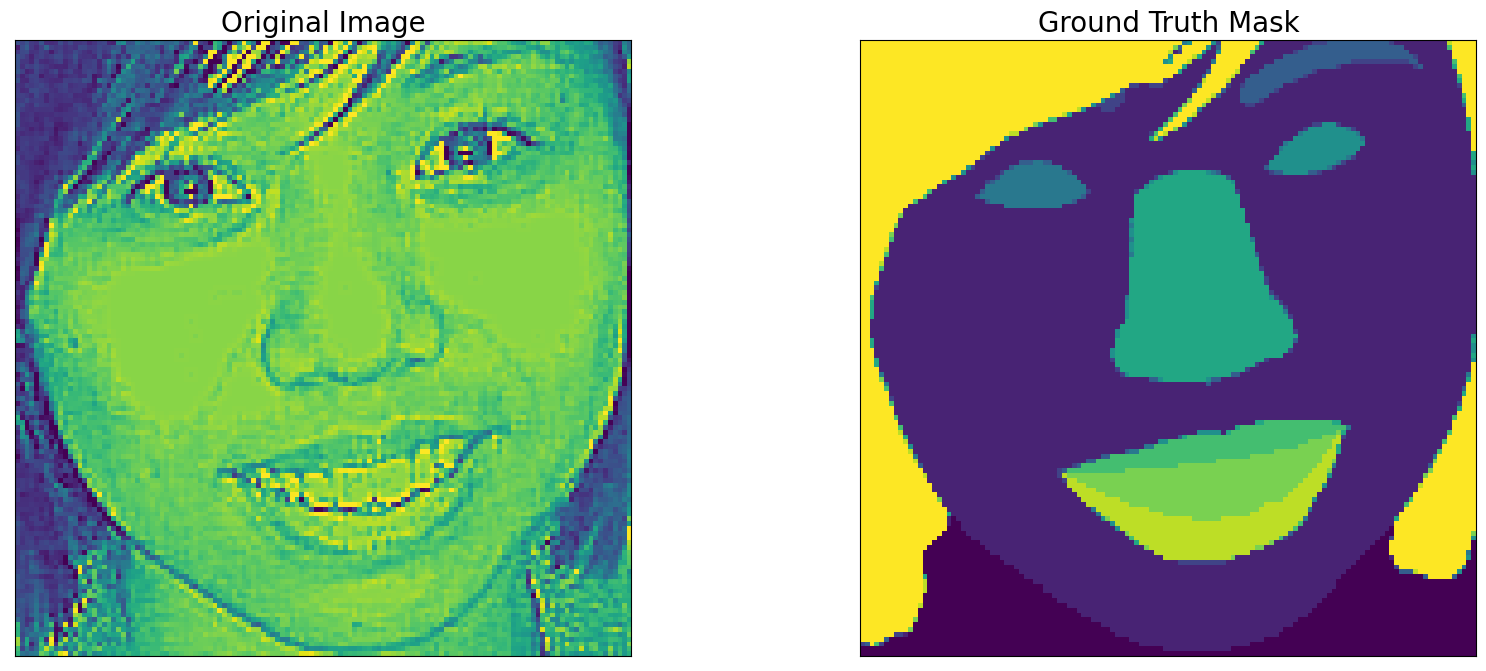

1 : (3, 128, 128) torch.Size([11, 128, 128])


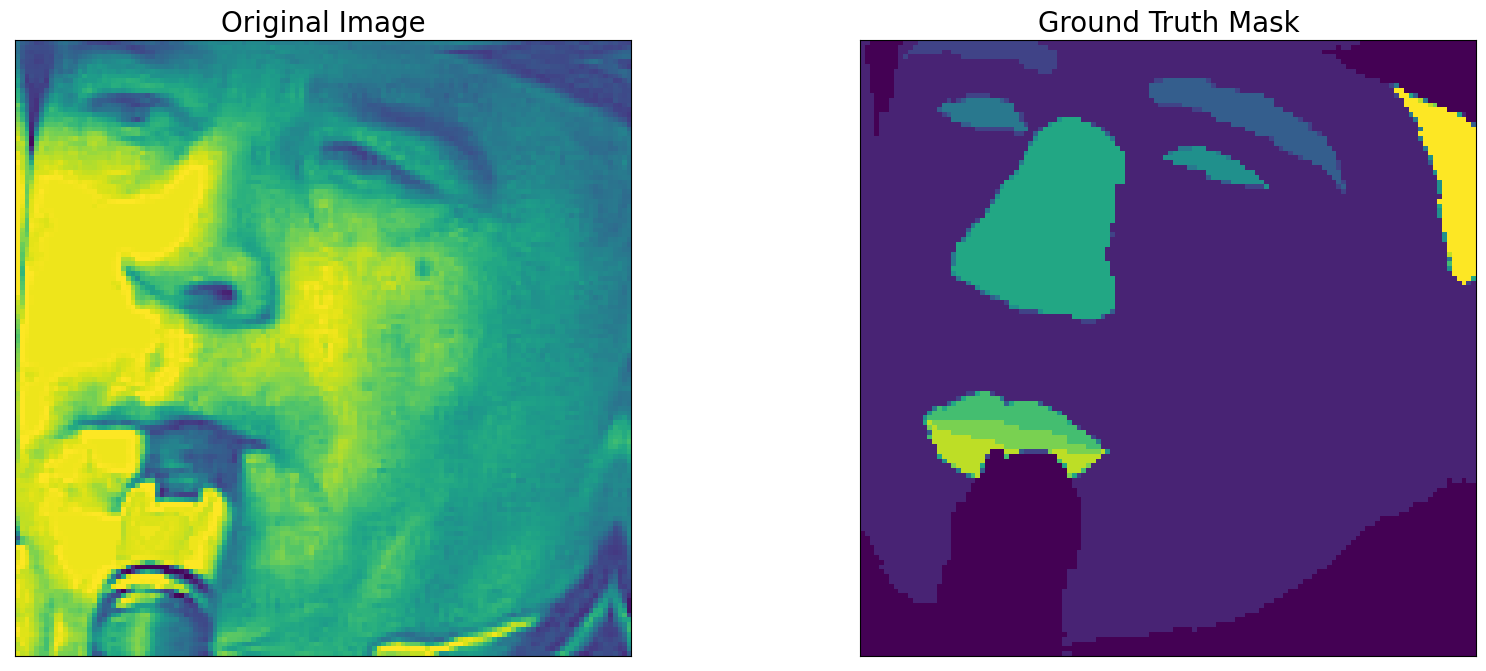

2 : (3, 128, 128) torch.Size([11, 128, 128])


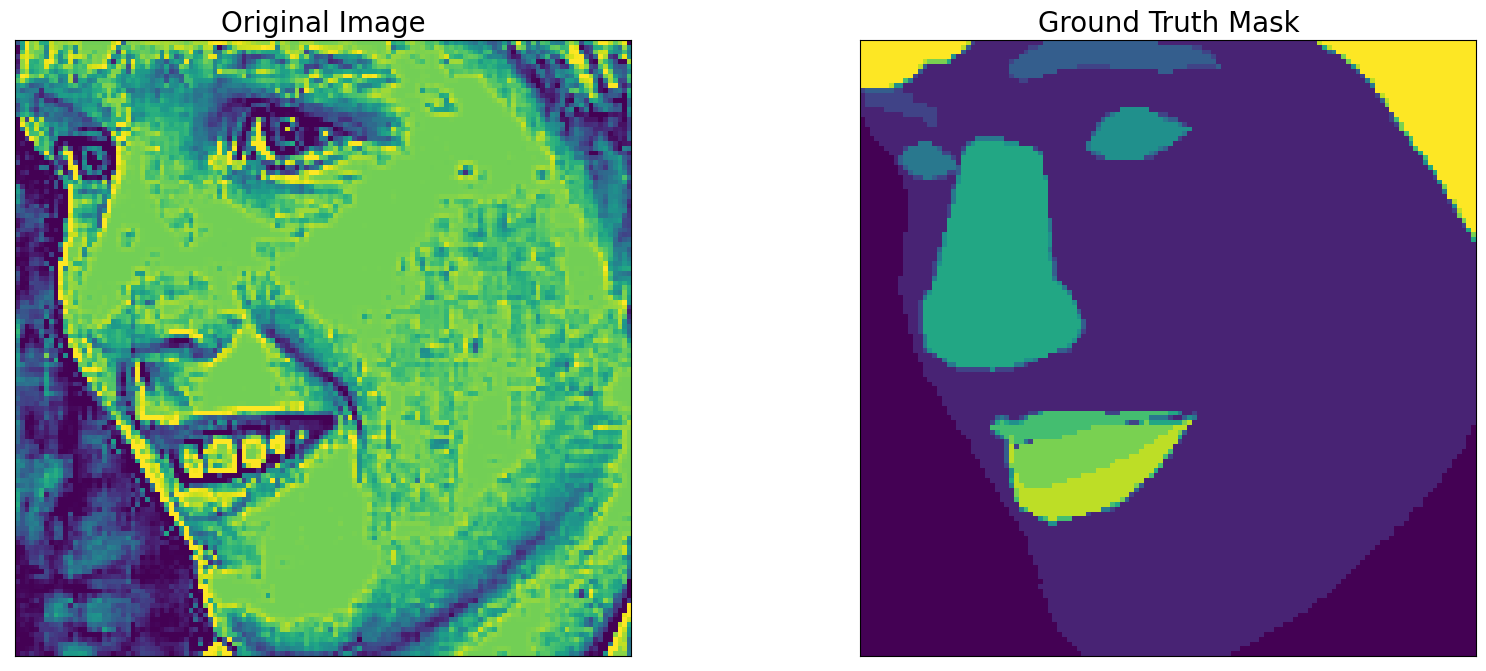

3 : (3, 128, 128) torch.Size([11, 128, 128])


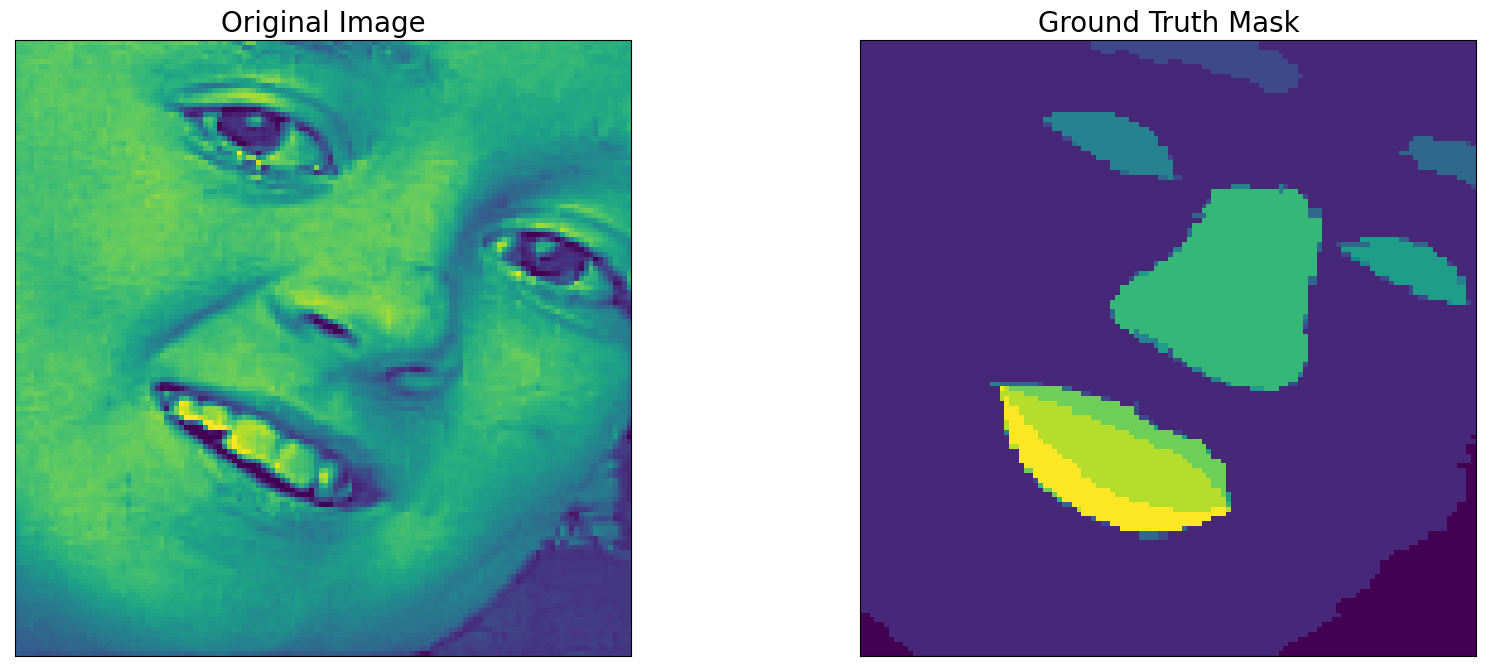

4 : (3, 128, 128) torch.Size([11, 128, 128])


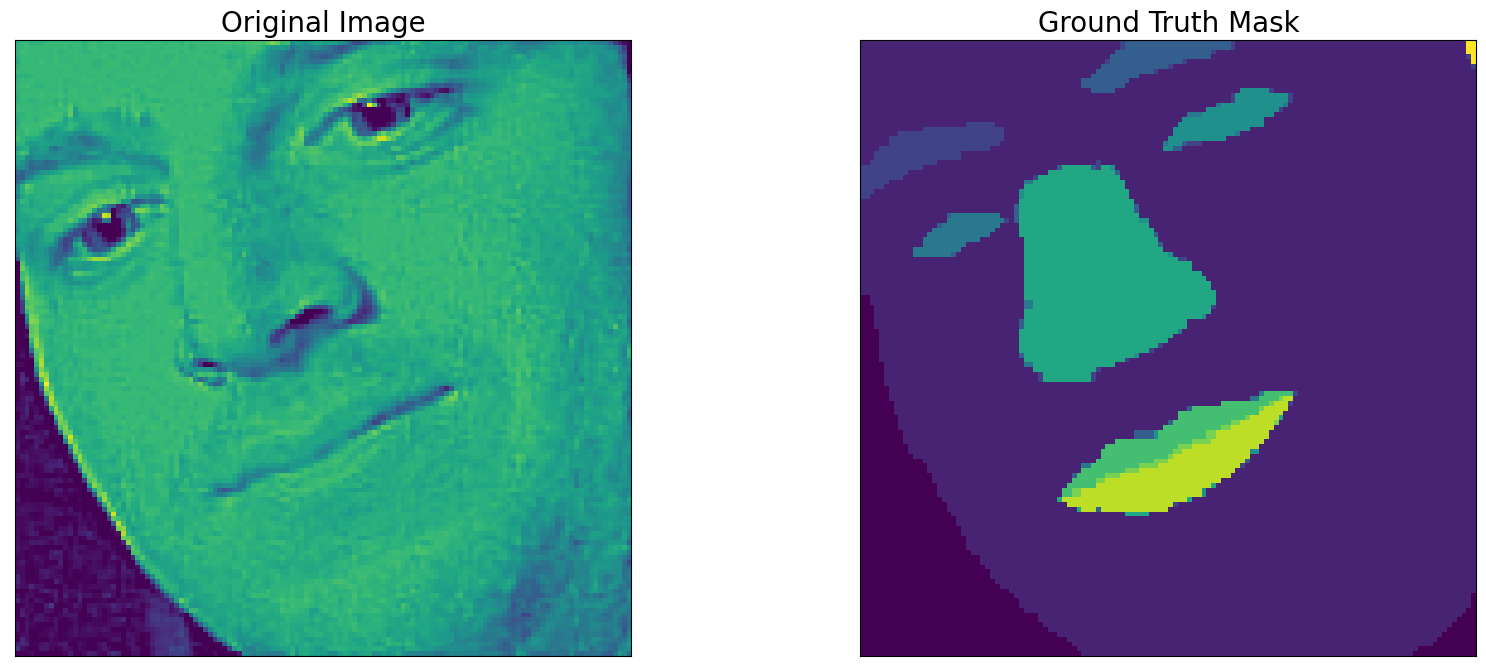

5 : (3, 128, 128) torch.Size([11, 128, 128])


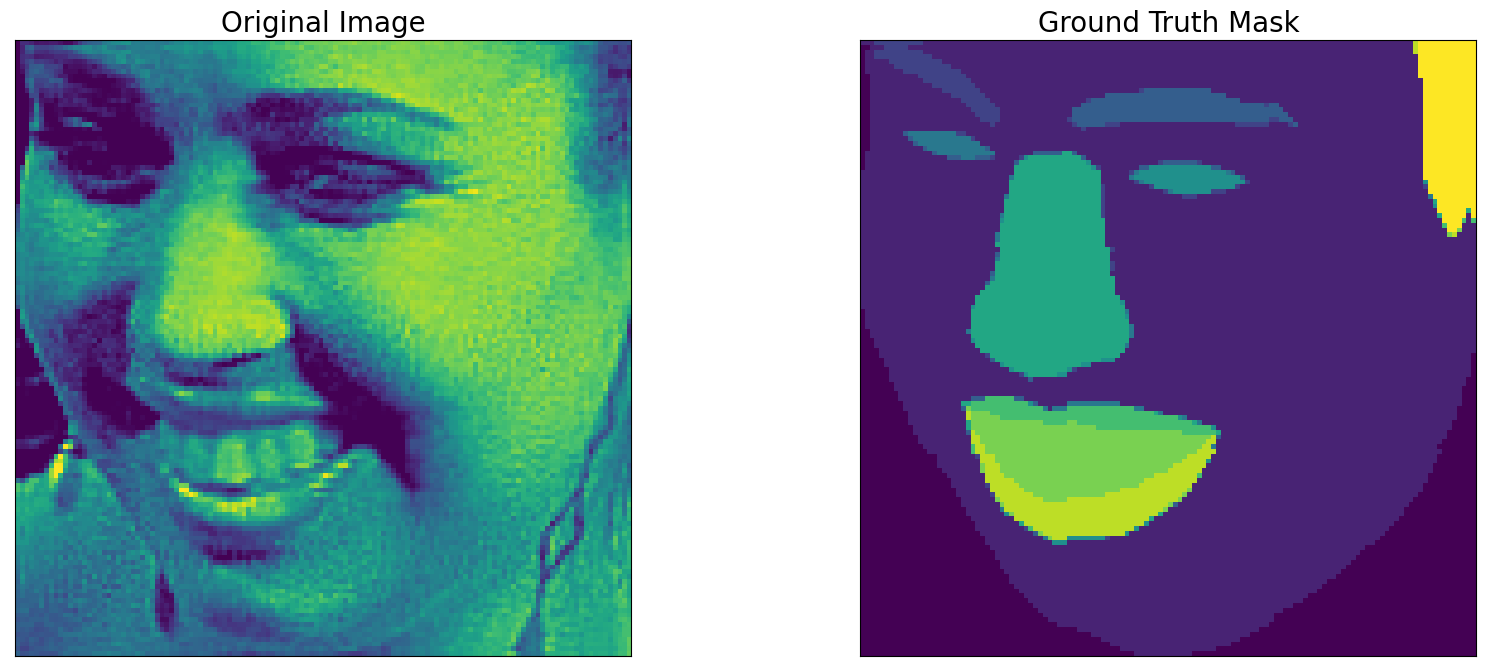

6 : (3, 128, 128) torch.Size([11, 128, 128])


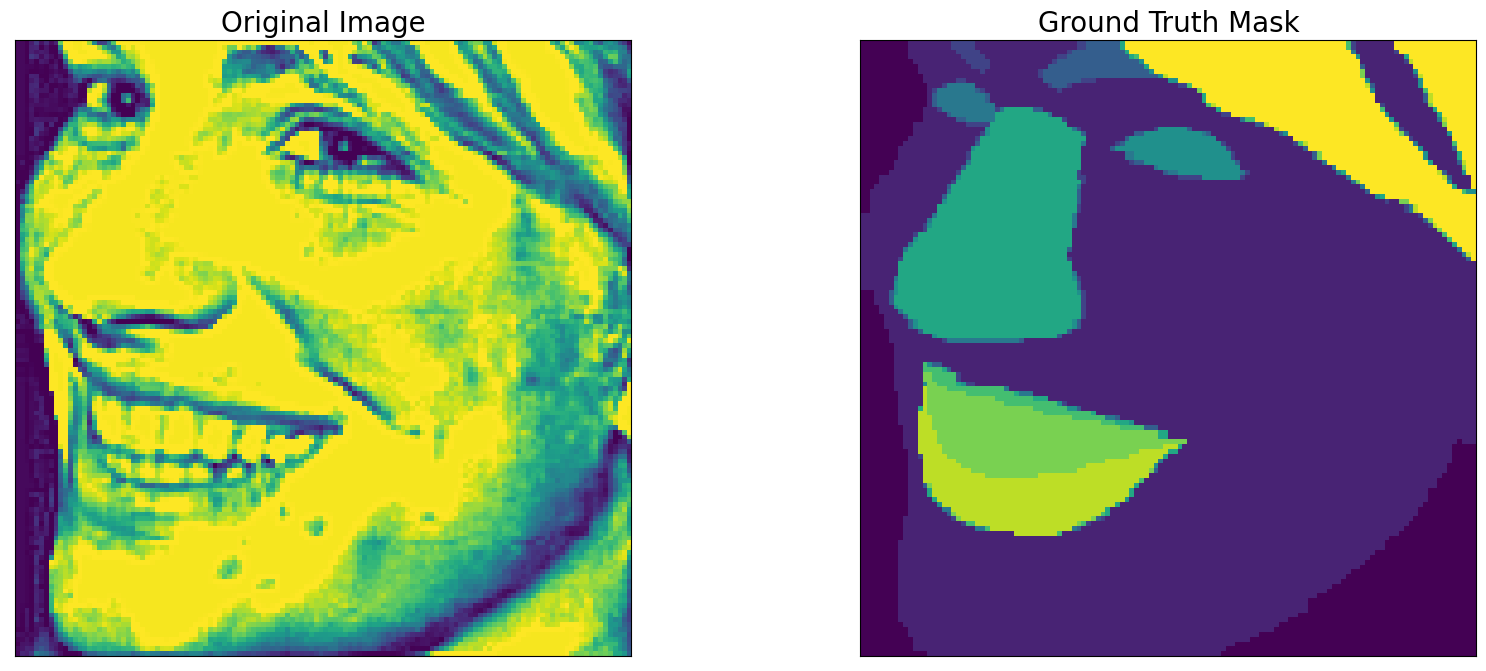

7 : (3, 128, 128) torch.Size([11, 128, 128])


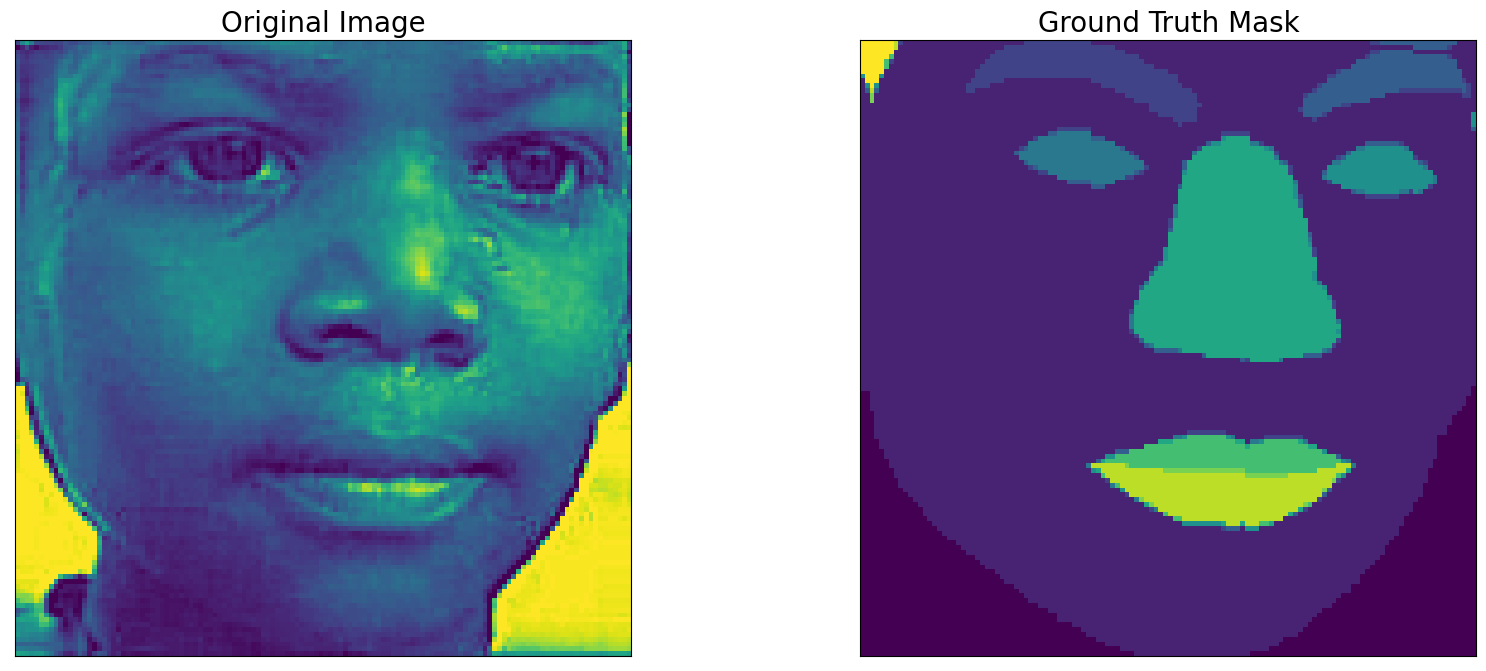

8 : (3, 128, 128) torch.Size([11, 128, 128])


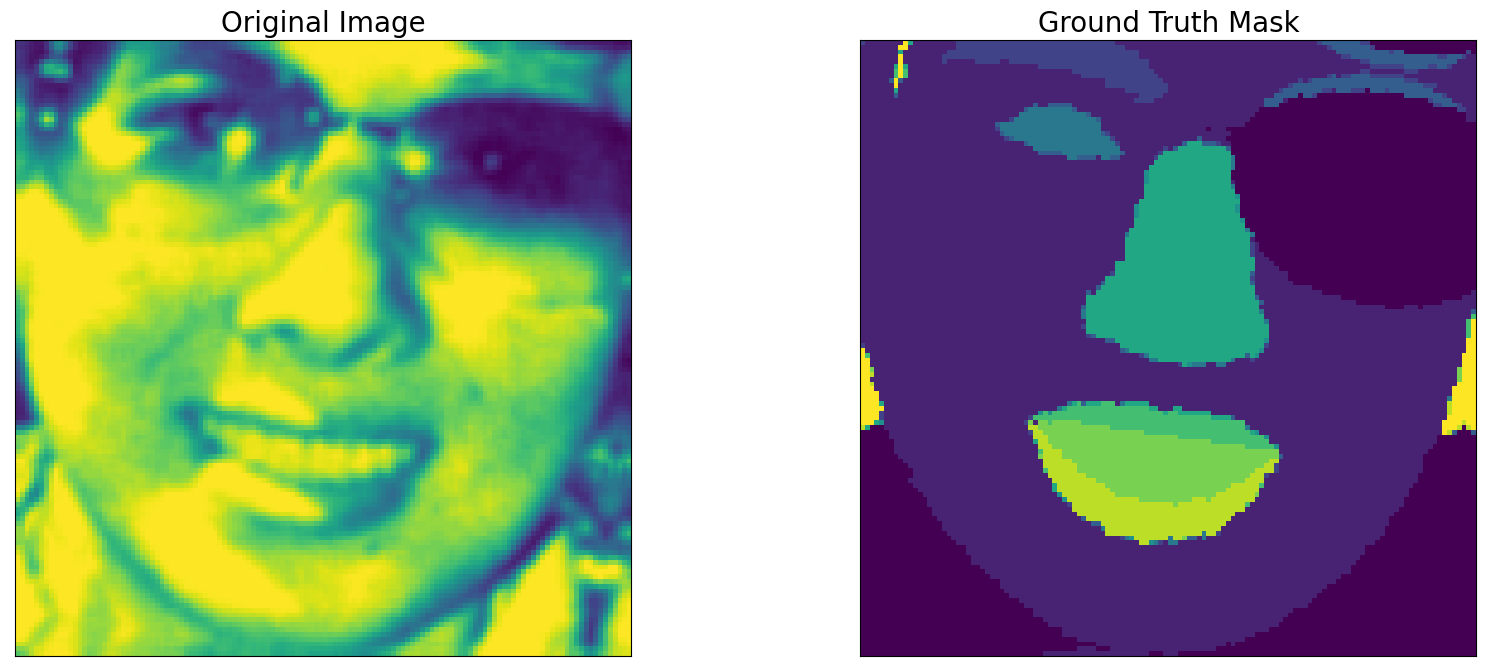

9 : (3, 128, 128) torch.Size([11, 128, 128])


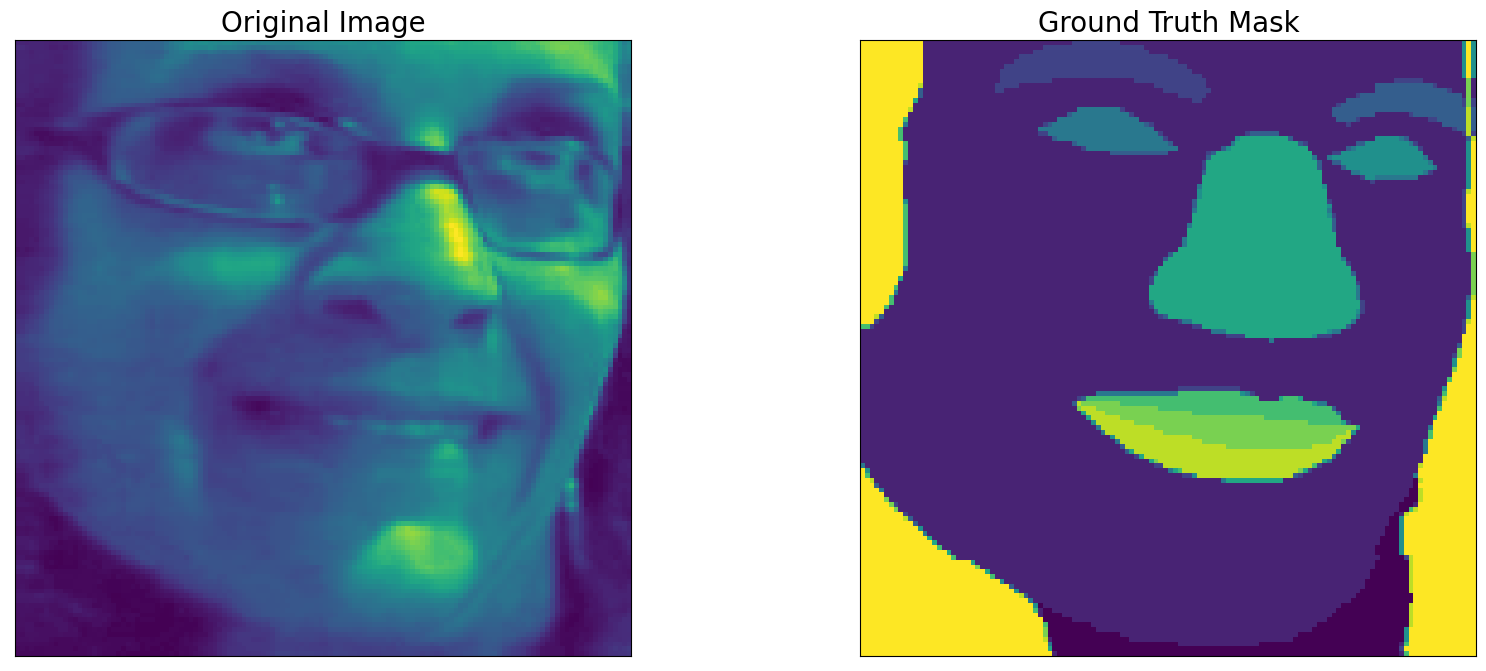

0 : (3, 128, 128) torch.Size([11, 128, 128])


/tmp/ipykernel_15278/2924039091.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


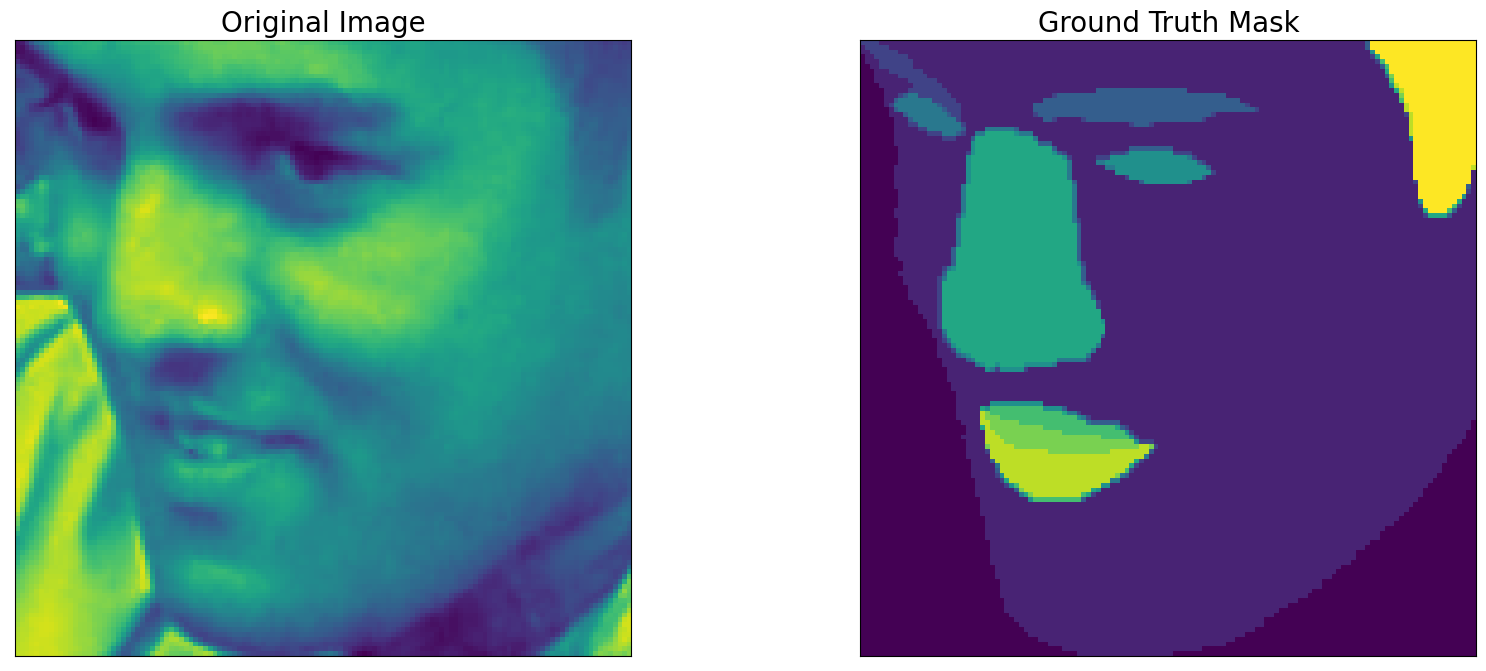

1 : (3, 128, 128) torch.Size([11, 128, 128])


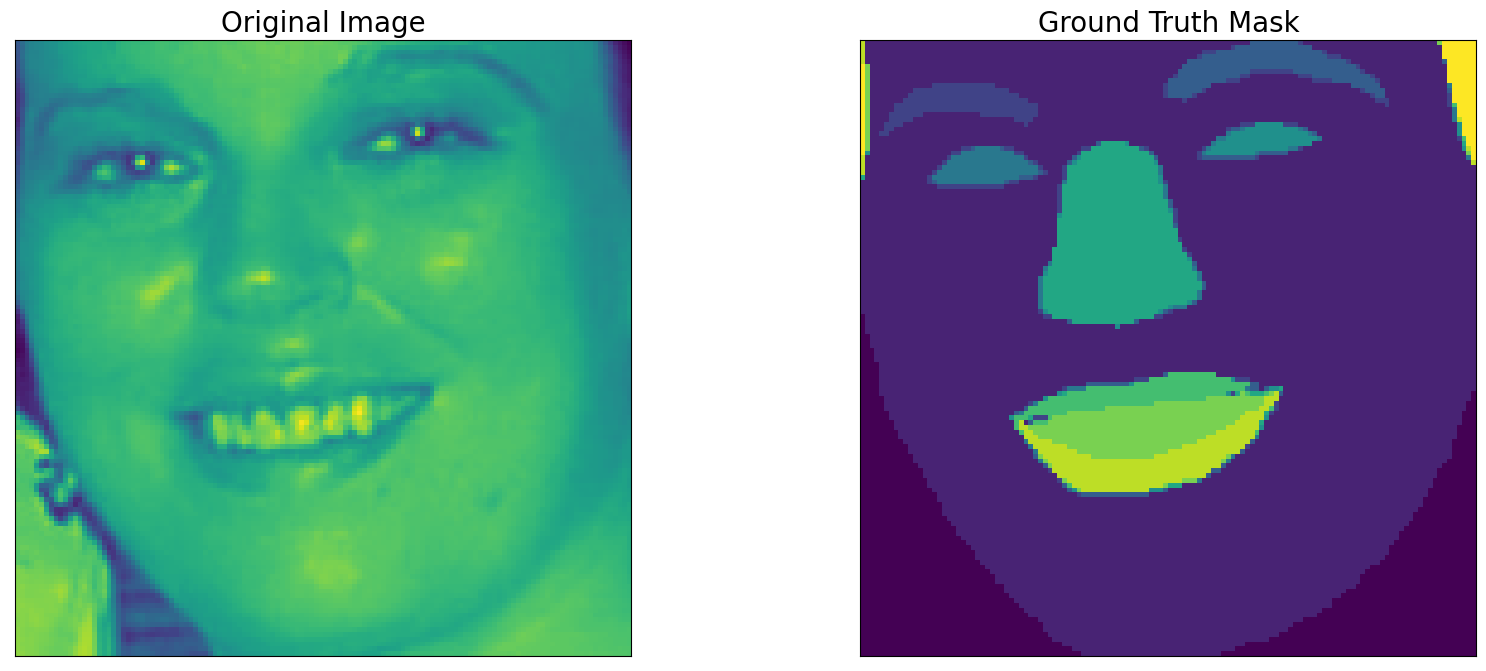

2 : (3, 128, 128) torch.Size([11, 128, 128])


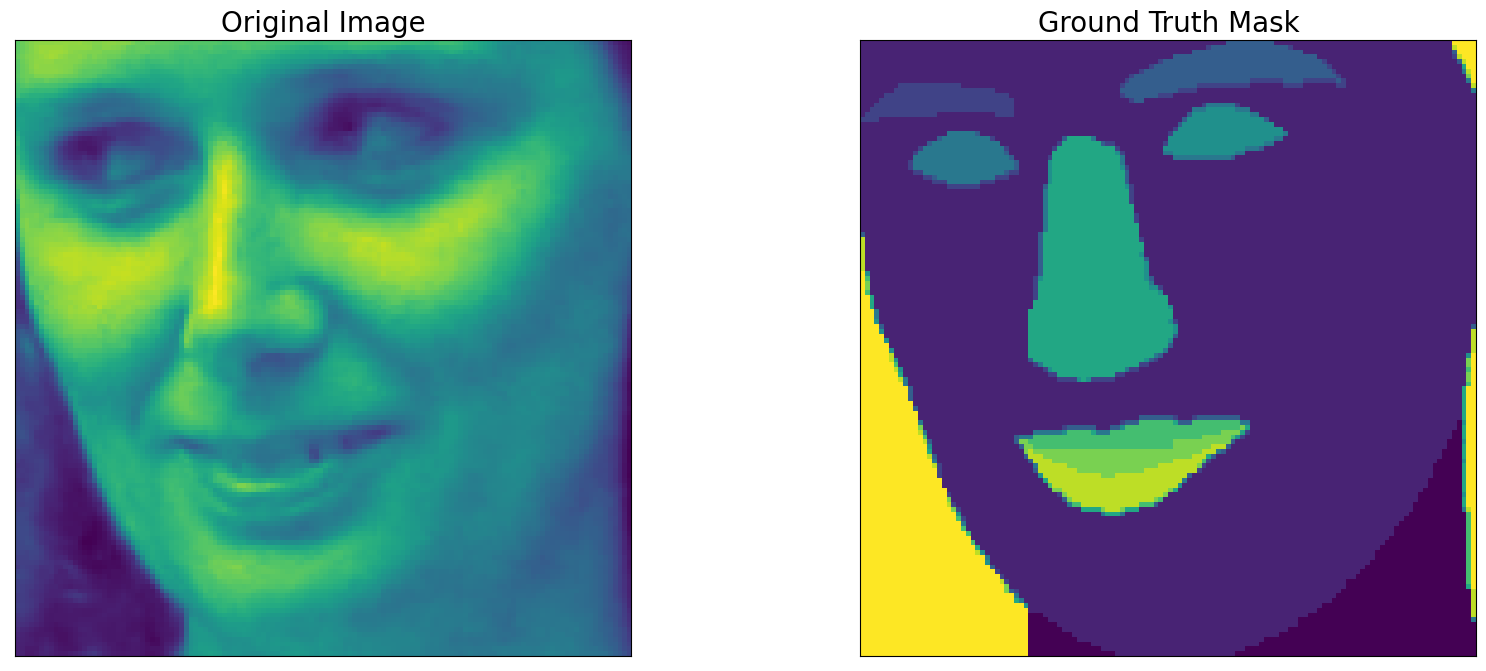

3 : (3, 128, 128) torch.Size([11, 128, 128])


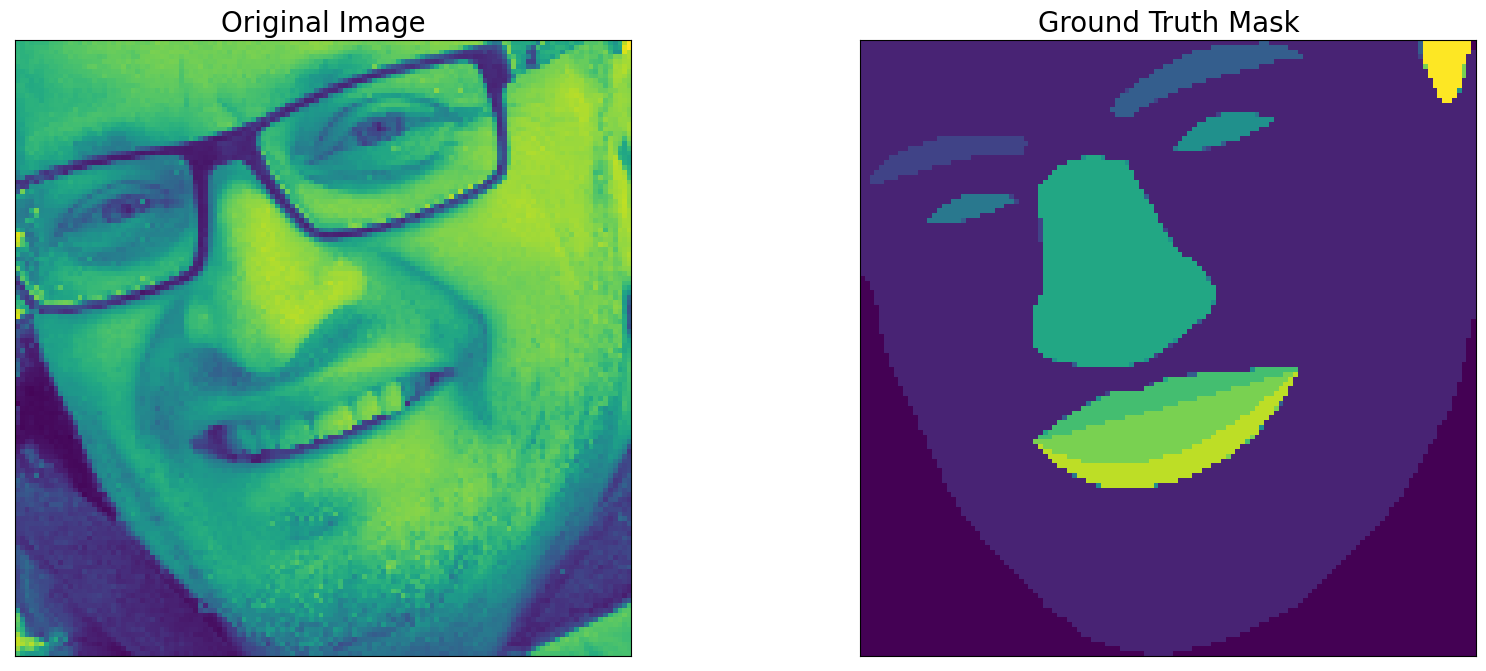

4 : (3, 128, 128) torch.Size([11, 128, 128])


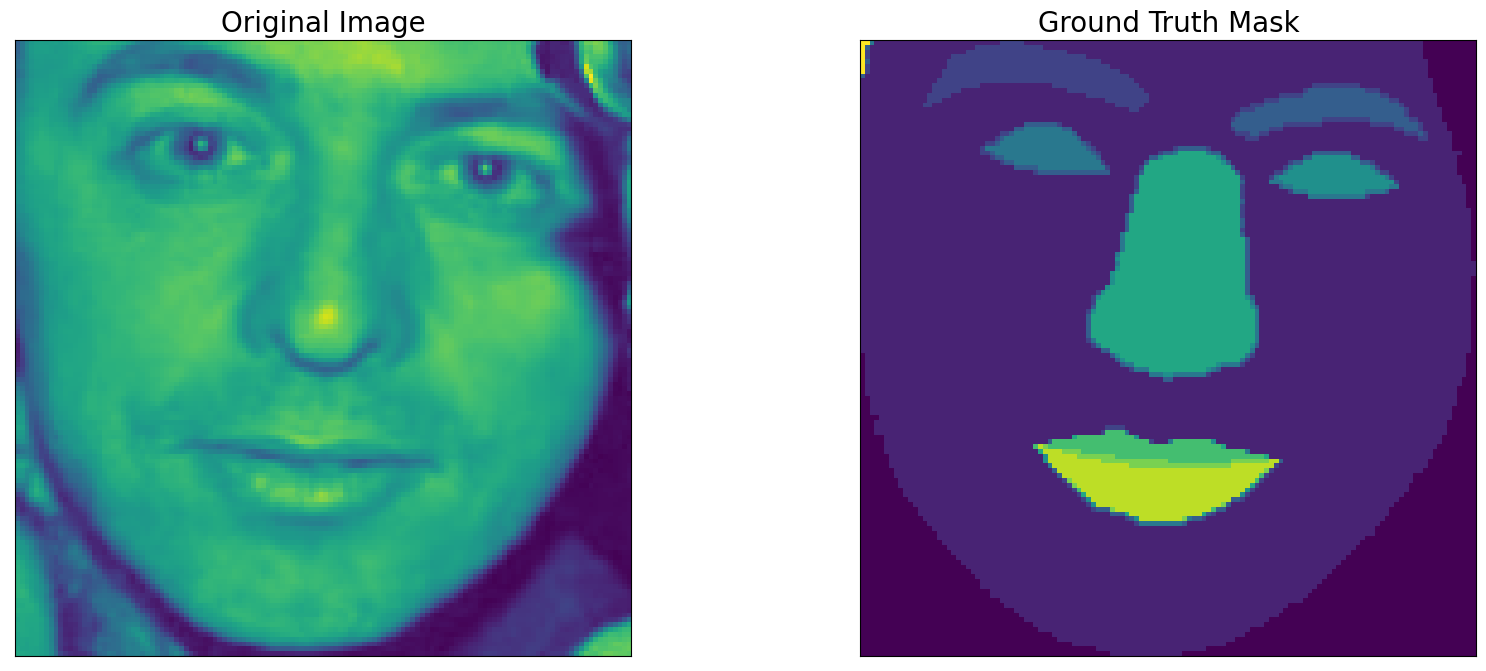

5 : (3, 128, 128) torch.Size([11, 128, 128])


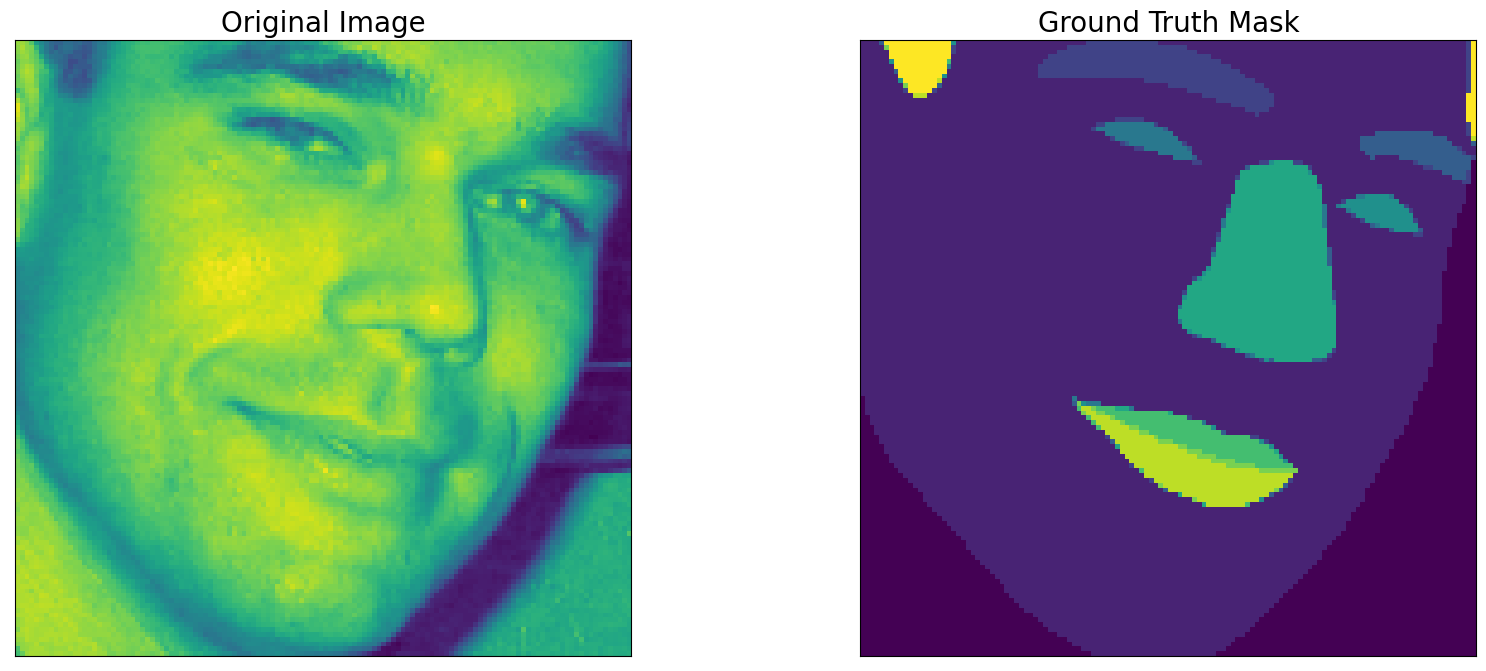

6 : (3, 128, 128) torch.Size([11, 128, 128])


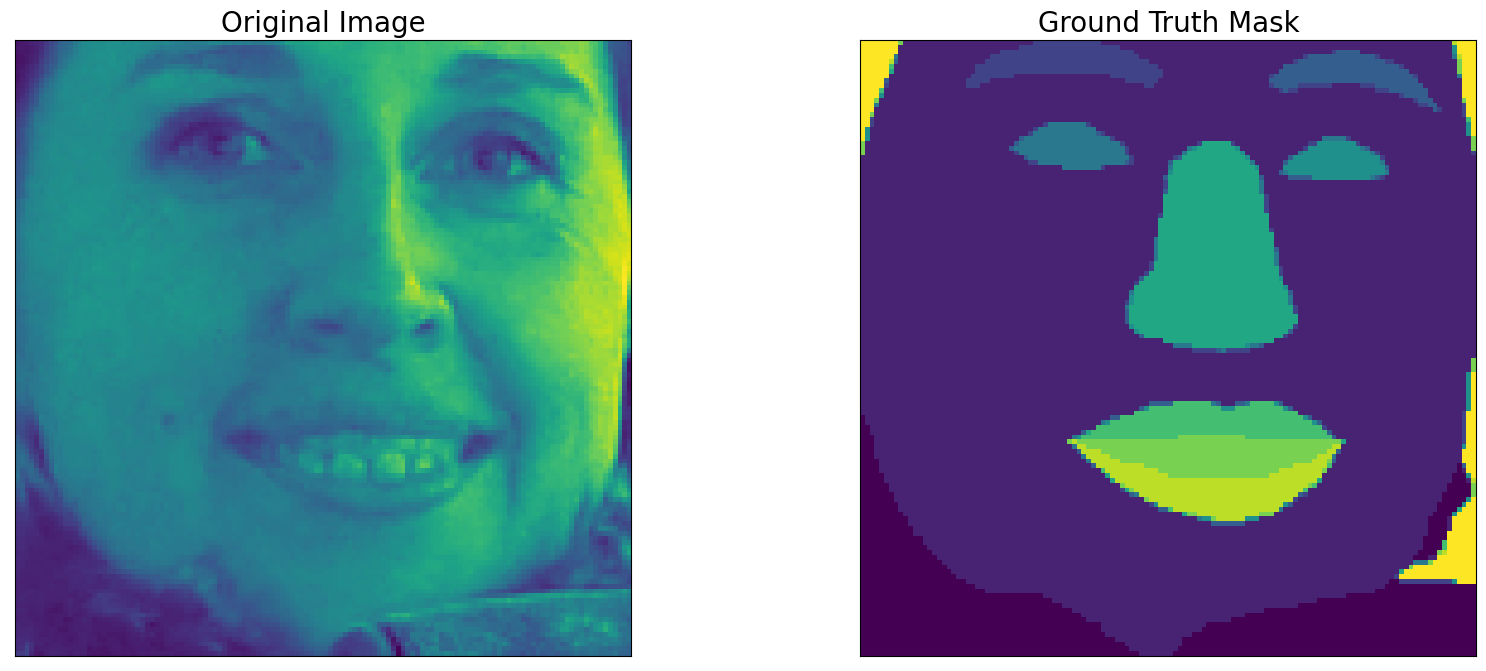

7 : (3, 128, 128) torch.Size([11, 128, 128])


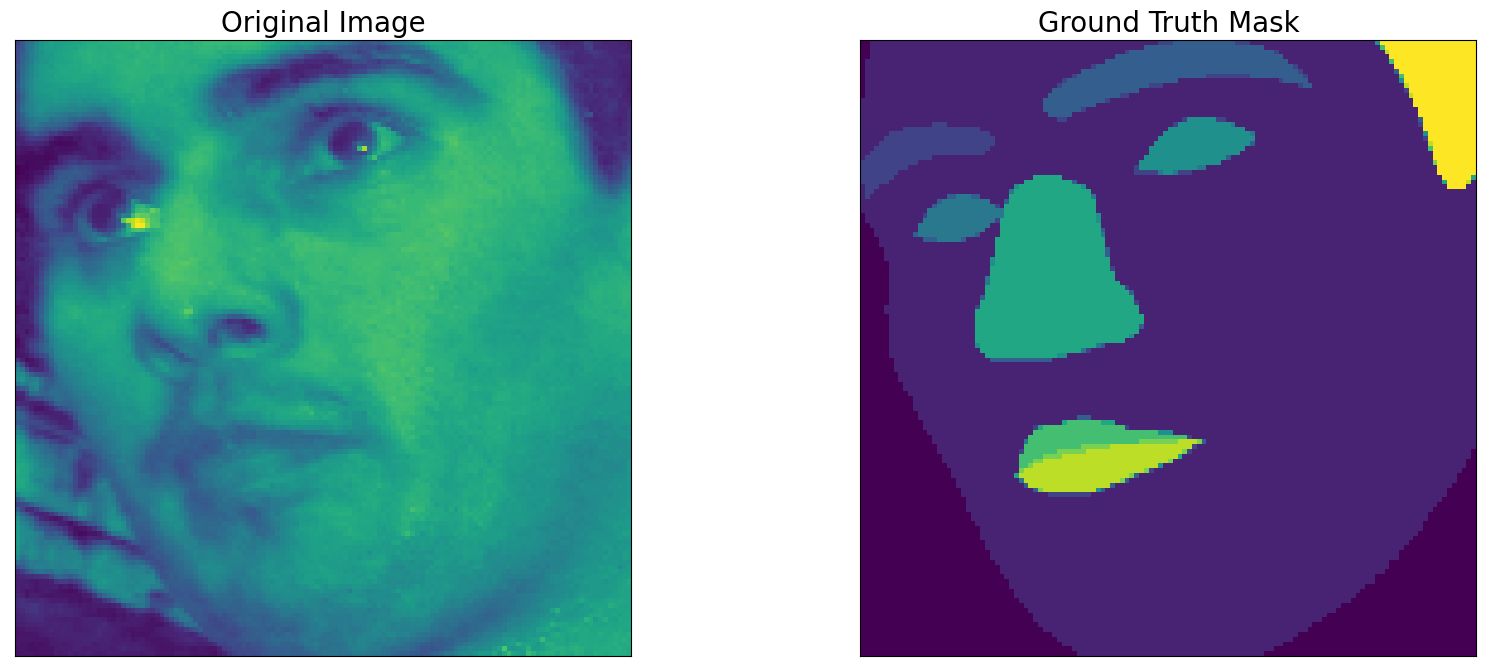

8 : (3, 128, 128) torch.Size([11, 128, 128])


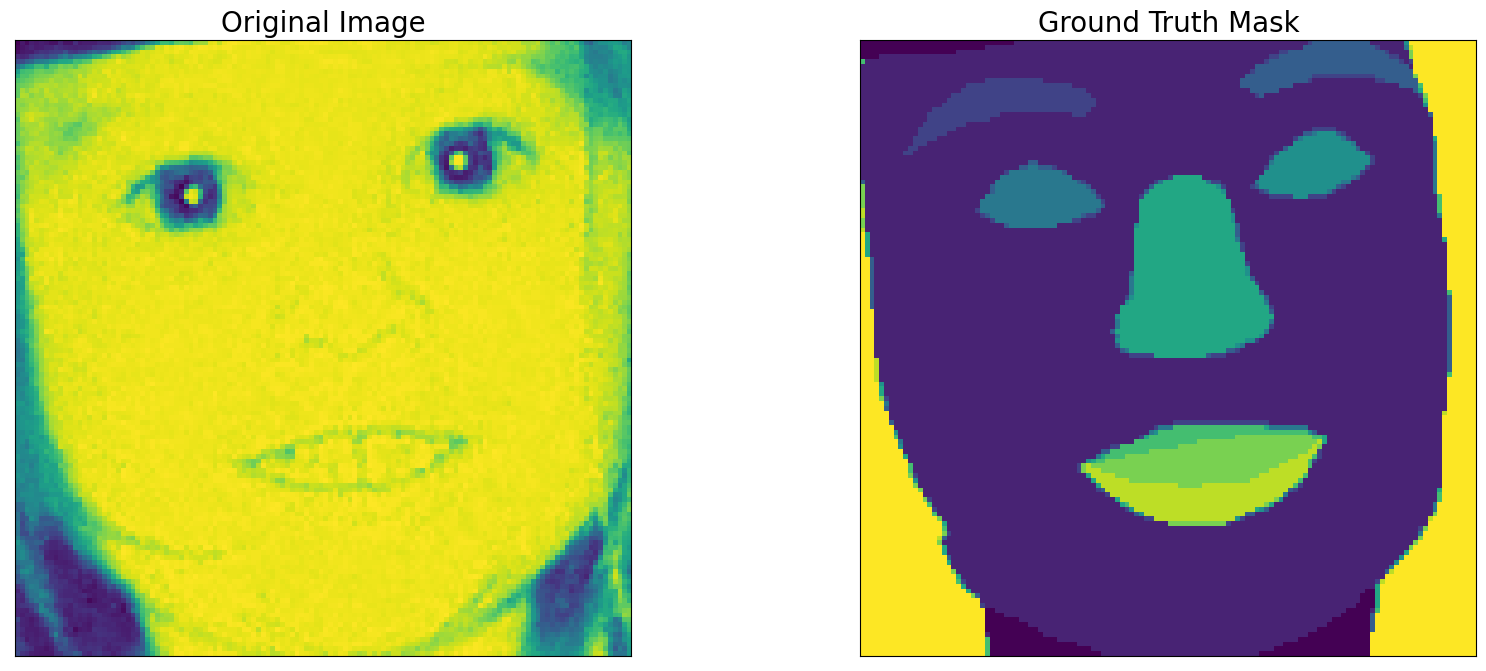

9 : (3, 128, 128) torch.Size([11, 128, 128])


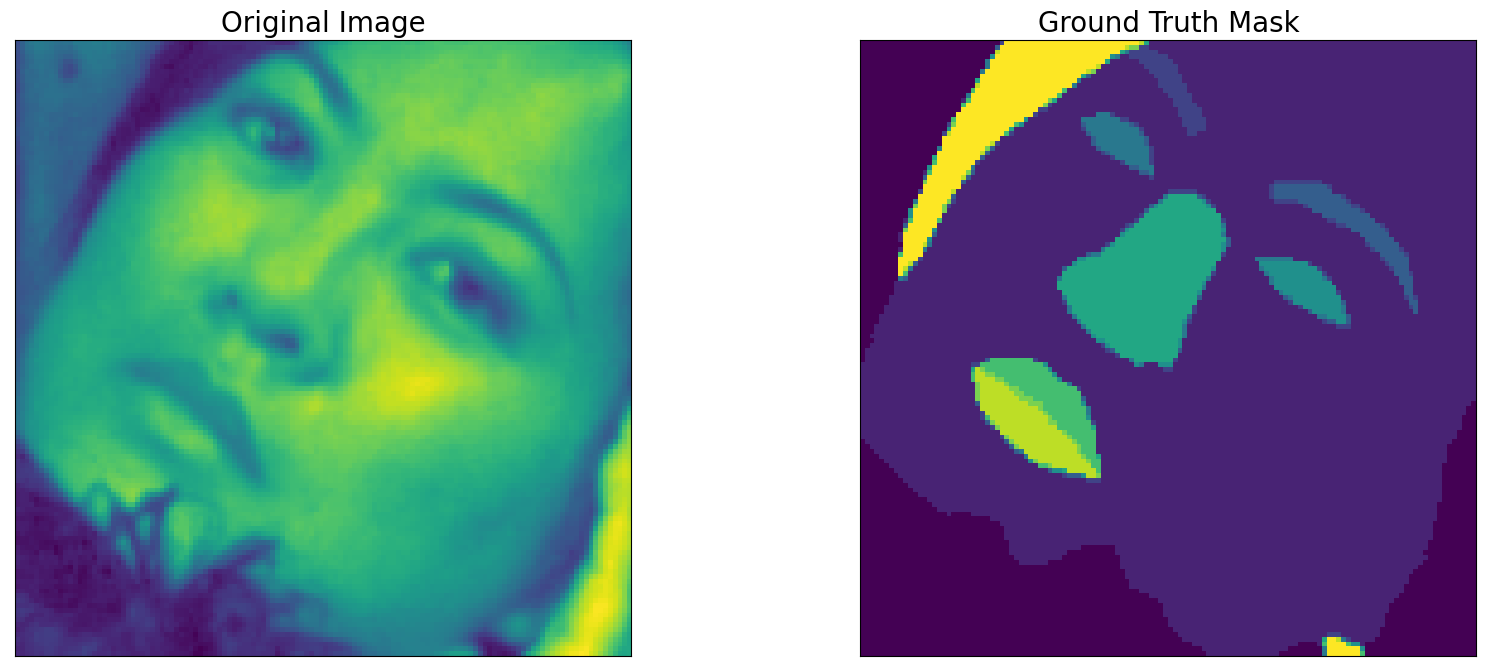

In [10]:
from matplotlib import pyplot as plt

for x in range(10):

  image_vis, gt_mask = train_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  binary_smoothed = scipy.signal.medfilt (gt_mask, 9)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

for x in range(10):

  image_vis, gt_mask = val_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  binary_smoothed = scipy.signal.medfilt (gt_mask, 9)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

#np.unique(image_vis)

### Data Loader

In [11]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=22)
valid_loader = DataLoader(val_ds, batch_size=24, shuffle=False, num_workers=22)

print(len(train_loader))

757


/home/nathan/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
image_vis, gt_mask = next(iter(train_loader))
print(image_vis.shape)
print(gt_mask.shape)

torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


### (DataLoader) Sanity check

TRAIN:
0
torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


/tmp/ipykernel_15278/2352336129.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


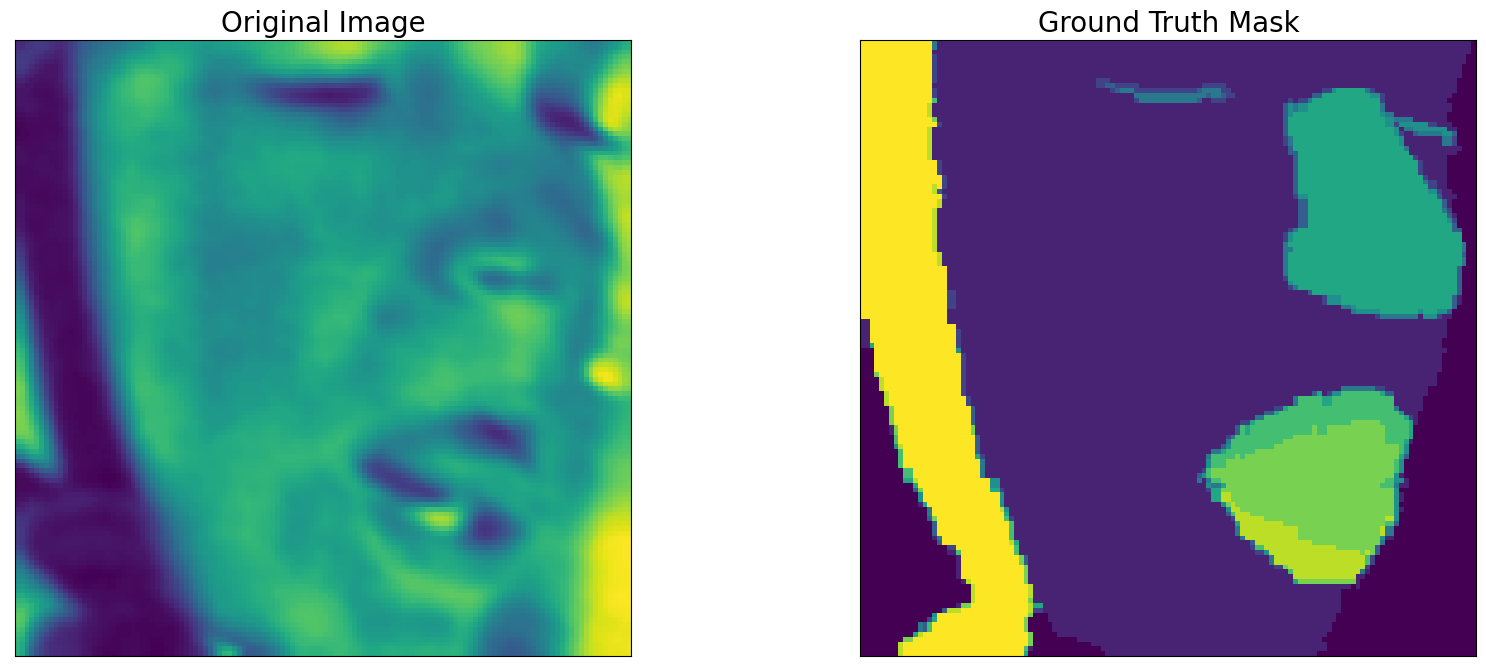

1
torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


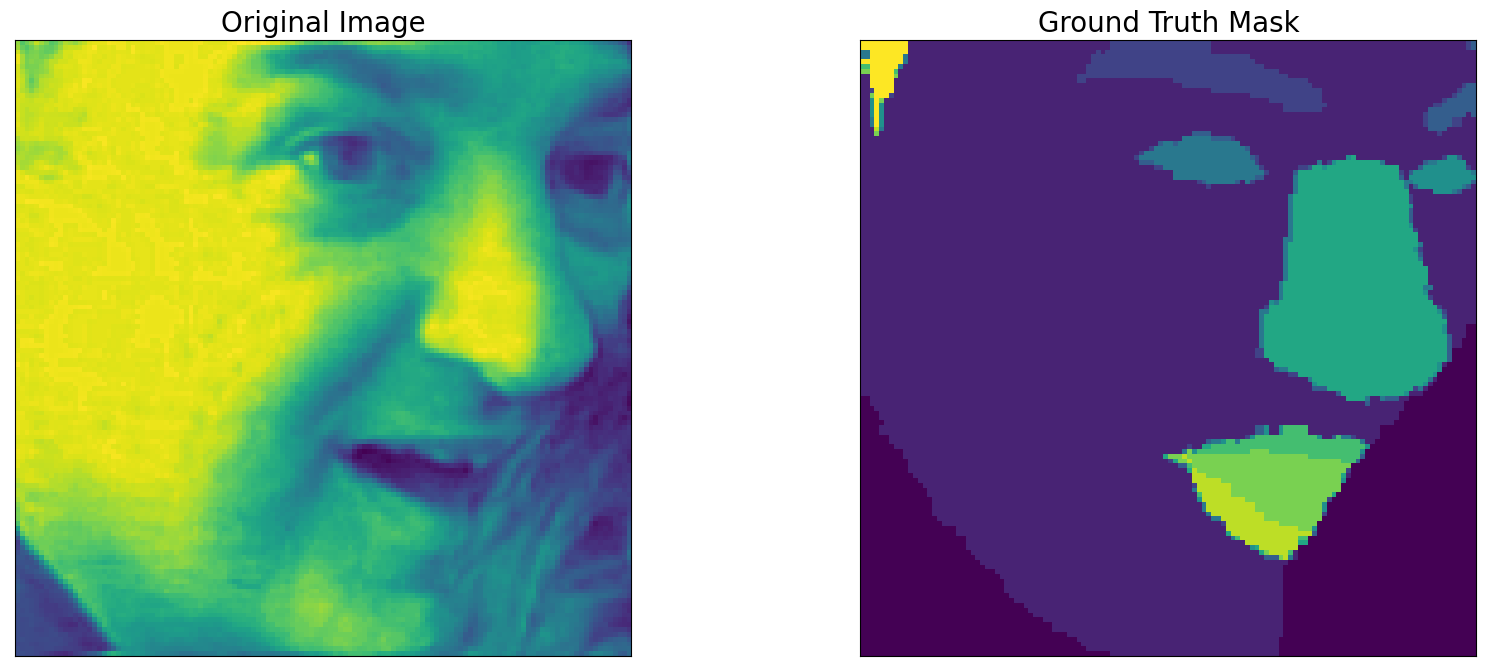

2
torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


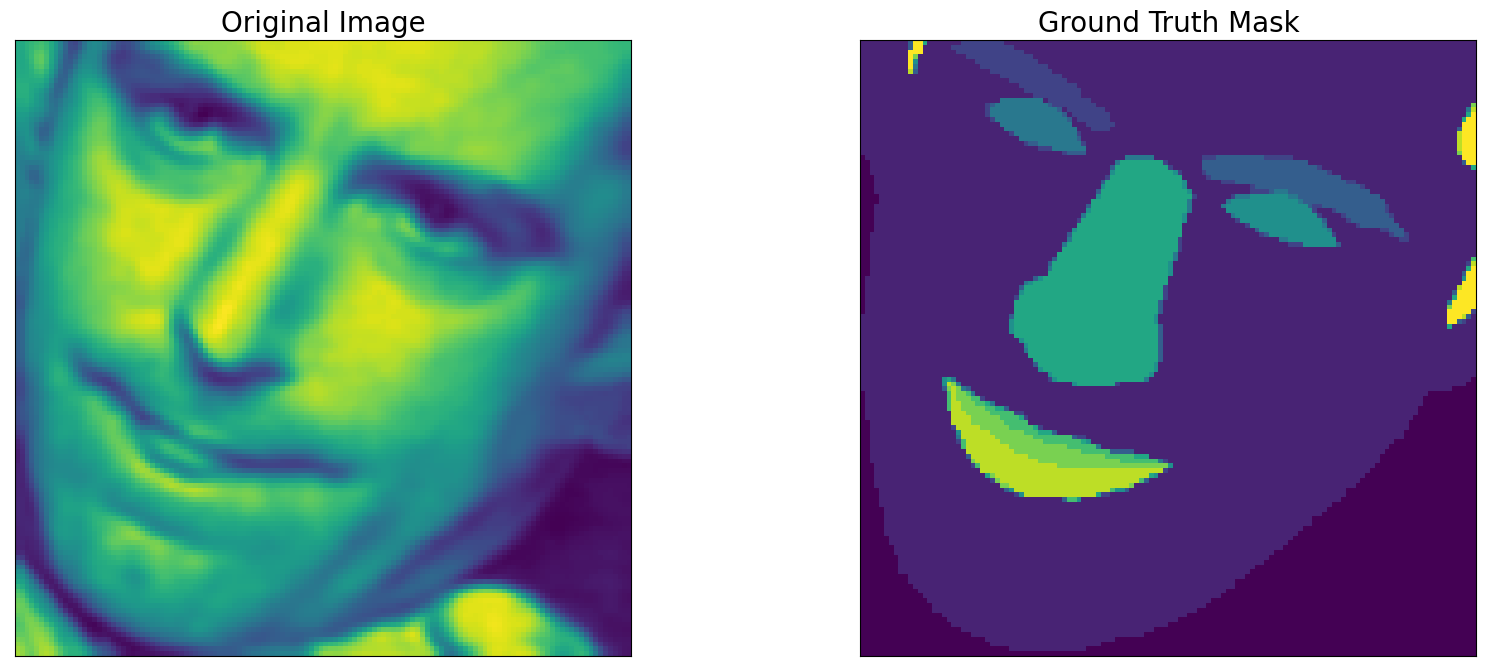

3
torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


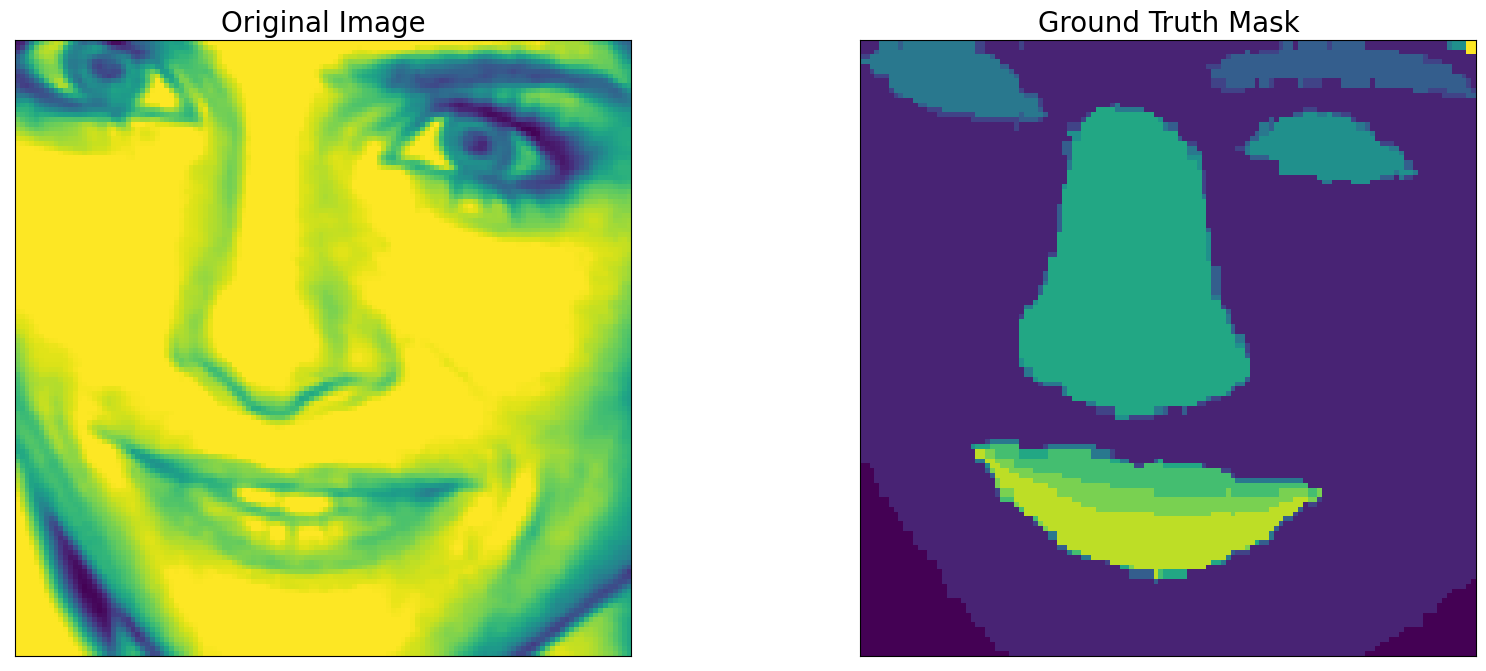

4
torch.Size([24, 3, 128, 128])
torch.Size([24, 11, 128, 128])


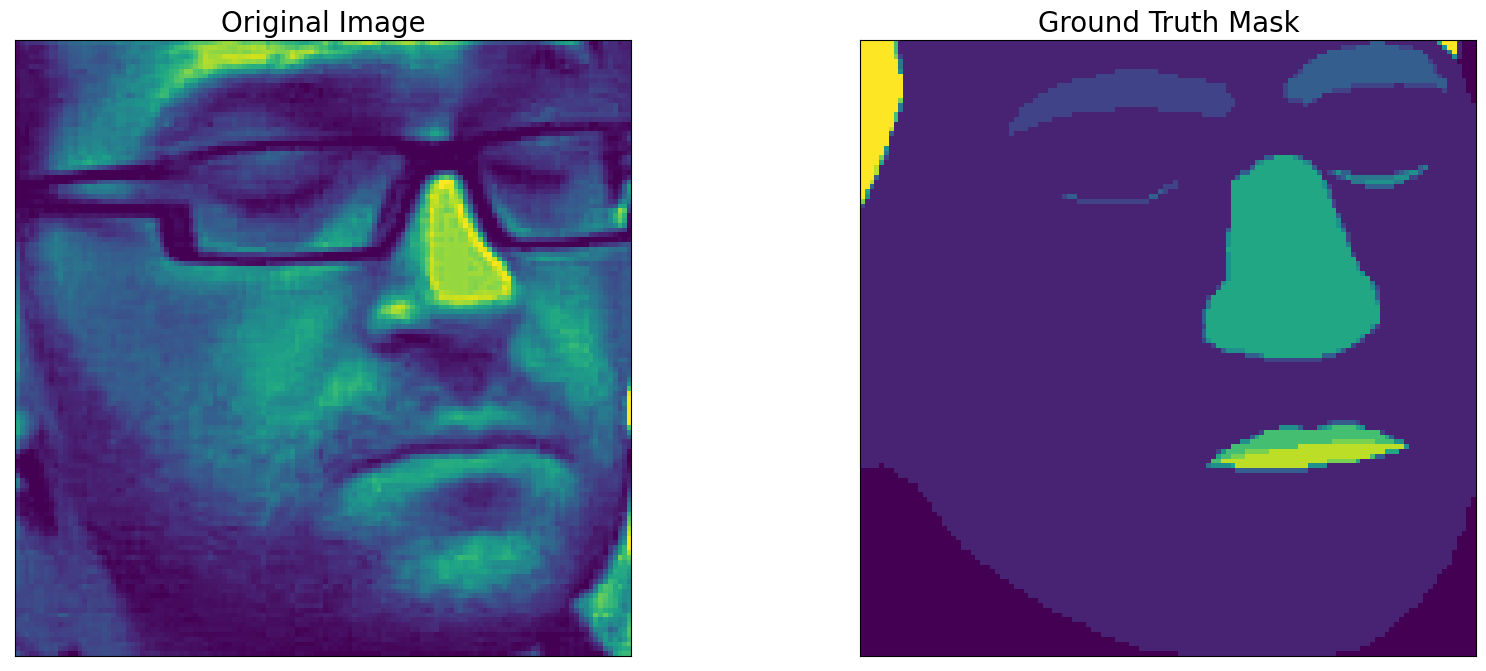

VAL:
torch.Size([24, 3, 128, 128])


/tmp/ipykernel_15278/2352336129.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


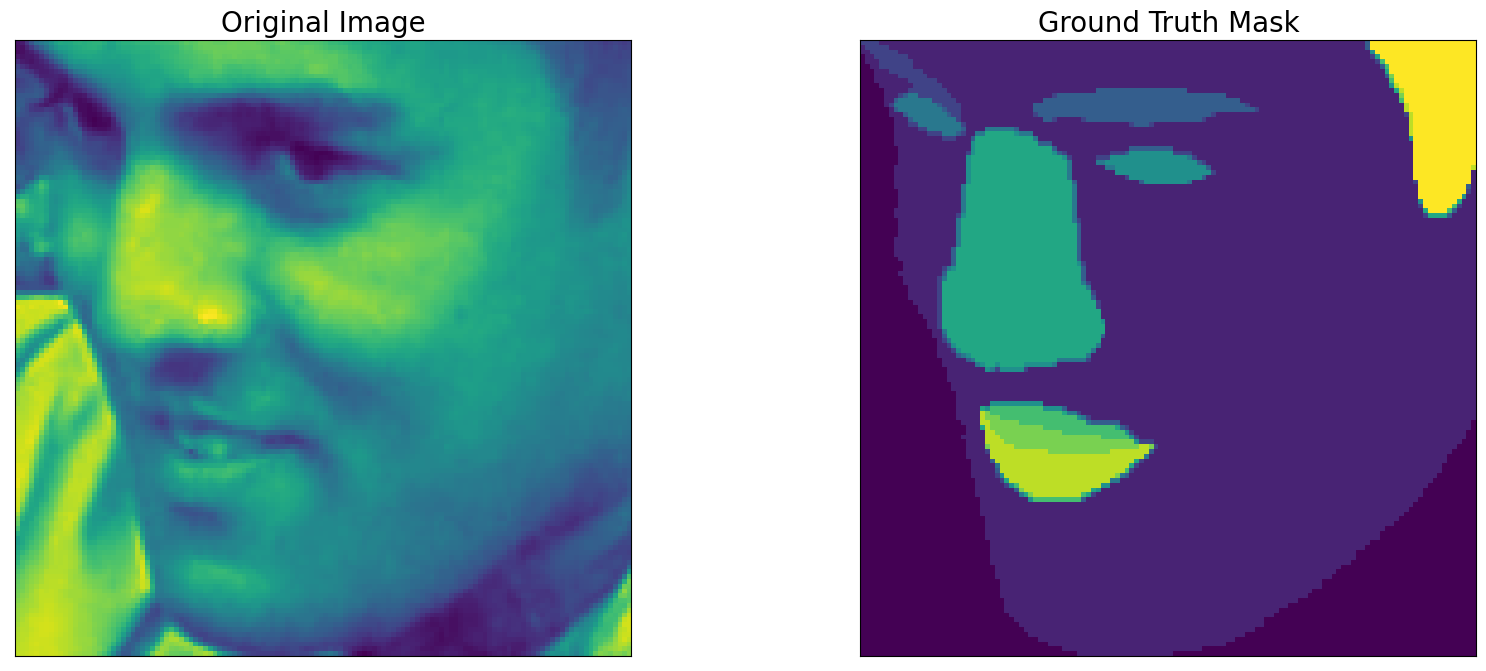

torch.Size([24, 3, 128, 128])


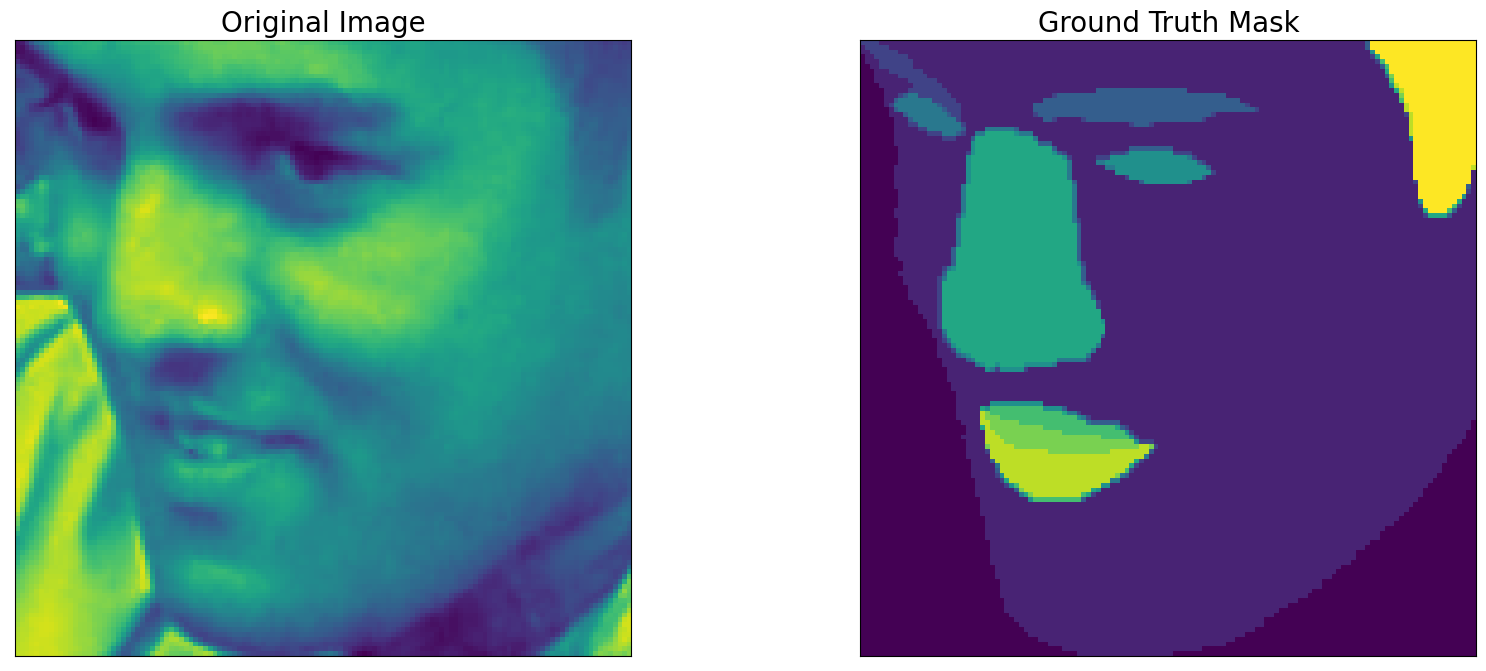

torch.Size([24, 3, 128, 128])


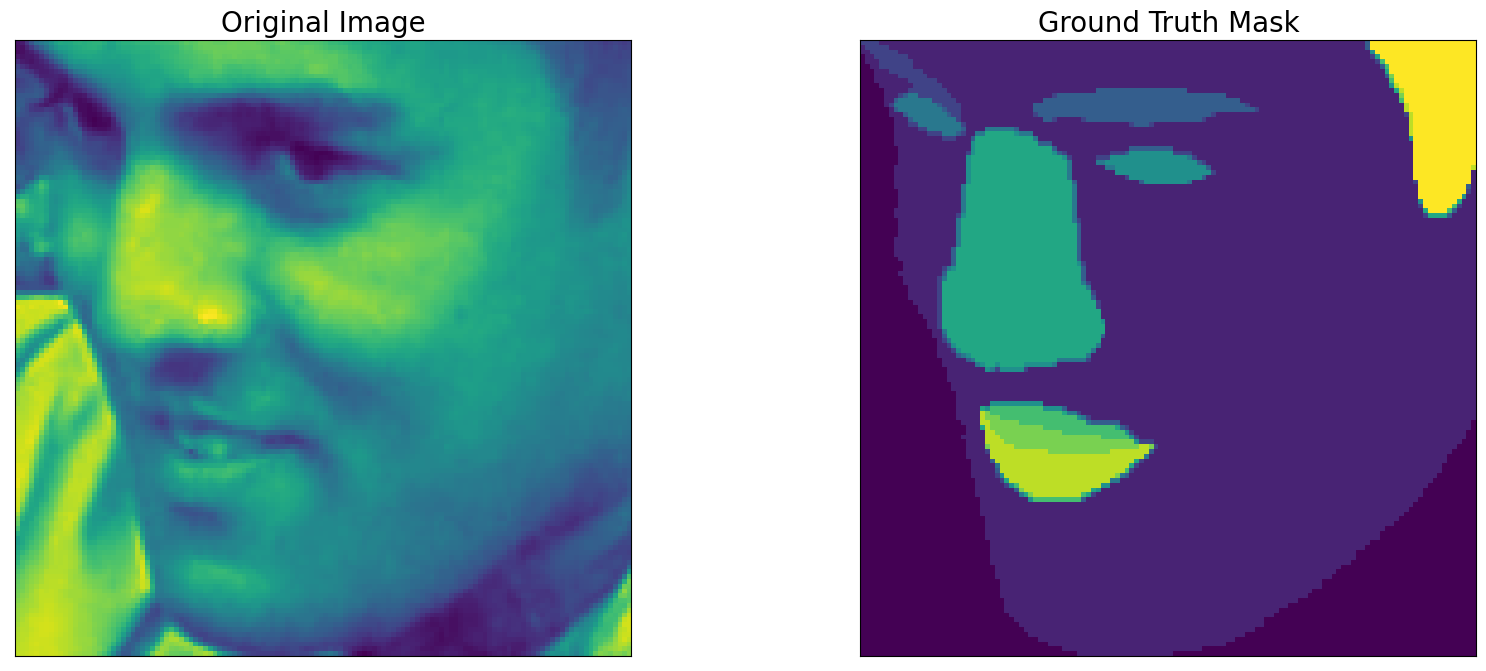

In [13]:
print("TRAIN:")
for x in range(5):

    image_vis, gt_mask = next(iter(train_loader))
    print(x)
    print(image_vis.shape)
    print(gt_mask.shape)

    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    
    visualize(
        original_image = image_vis[0,::][0,::],
        ground_truth_mask = gt_mask[0,::]
    )
print("VAL:")
for x in range(3):

    image_vis, gt_mask = next(iter(valid_loader))
    print(image_vis.shape)

    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    visualize(
        original_image = image_vis[0,::][0,::],
        ground_truth_mask = gt_mask[0,::]
    )

## Hyper Params

In [14]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing

weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights



tensor([0.9027, 0.3298, 0.9813, 0.9836, 0.9885, 0.9888, 0.9210, 0.9866, 0.9858,
        0.9784, 0.9533])

In [296]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#[0.1, 1, 1, 1, 1, 1, 0.8, 1, 0.8, 1, 0.1]
#weights = weights=torch.tensor()
# define loss function
#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


## Train Model

In [300]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    #optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            if best_iou_score>0.8:
              optimizer.param_groups[0]['lr'] = 1e-5
              print('Decrease decoder learning rate to 1e-5!')
                
            # Append results to graphs:
           # v_bce.append(valid_logs['bce_loss'])
            v_ious.append(valid_logs['iou_score'])
            
            #t_bce.append(train_logs['bce_loss'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                #plt.plot(epoch_count,t_bce, label="Train ce")
#plt.plot(epoch_count,v_bce, label="Valid ce")
                #.legend(loc="upper left")
               # plt.xlabel("Epochs")
               # plt.ylabel("BCE Loss")
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


### Function to view train model precitions

In [17]:
! pip install torchmetrics

/bin/bash: /home/nathan/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [19]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        #print("vis:",image_vis.shape)
        #print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        #print("predraw", pred_mask.shape)
        #print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          #print(f1)
          f1s.append(np.array(f1))

        if idx == 2:
          visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

/tmp/ipykernel_47277/3358991338.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [90]:
from torchvision.utils import save_image
from PIL import Image



def save_predictions(model, ds):

  #predict
  for idx in range(len(ds)):

      # Pop image from DS
      image, gt_mask = ds[idx]
      image_vis = image
      image_vis = np.transpose(image_vis,(1,2,0))
      
      # Reshape
      x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(x_tensor)
      # Reshape
      pred_mask = pred_mask.detach().squeeze().cpu()
      
      # Decode Onehots
      pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
      gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

      pred_mask = Image.fromarray(np.uint8(pred_mask)).save("/home/nathan/Documents/final_project/datasets/label_adapter/images/"+str(idx)+".png",quality='keep')
      gt_mask = Image.fromarray(np.uint8(gt_mask)).save("/home/nathan/Documents/final_project/datasets/label_adapter/masks/"+str(idx)+".png",quality='keep')

      #gt_mask = scipy.signal.medfilt(gt_mask, 9)

      print("saving", idx, "/", len(ds))

      # Save Predictions for use in Label Adapter
      # xs.append(pred_mask)
      # ys.append(gt_mask)
      

# Predict with models

In [20]:
#train_model(unet, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", 50)
#train_model(fcn, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", 20)
#train_model(mobile, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", 20)
#train_model(deeplab, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", 20)

### Load and view model predictions

LAPA:


/tmp/ipykernel_47277/3358991338.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


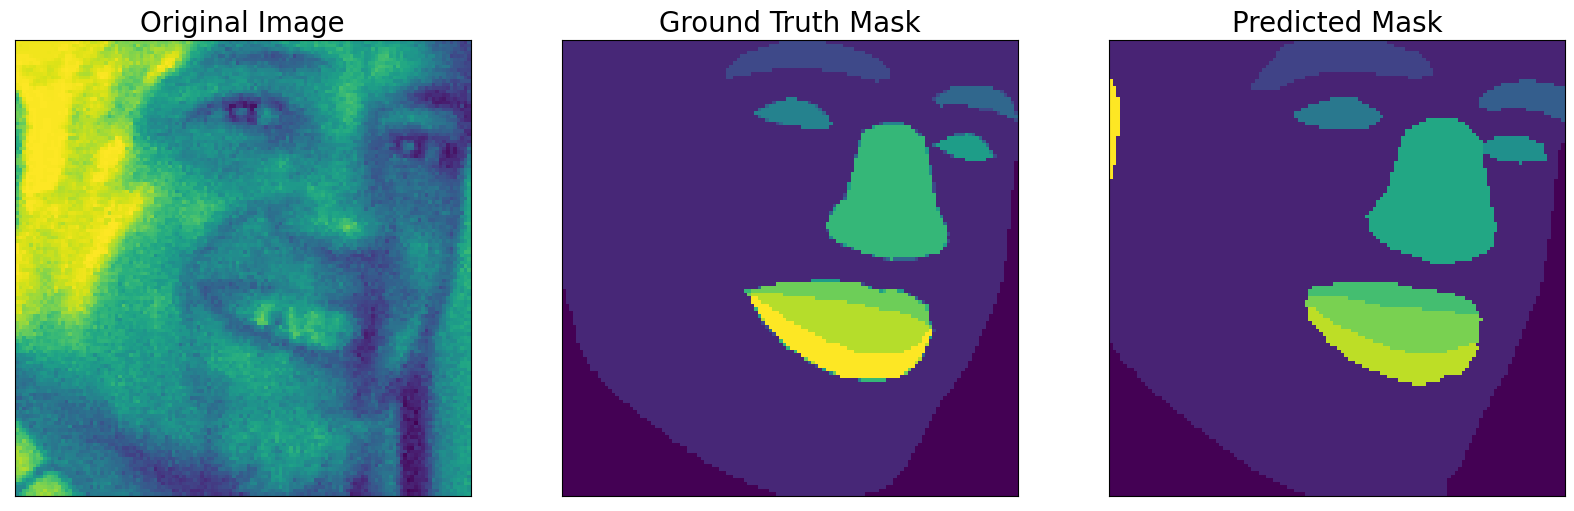

Dataset MIoU =  0.6306062814369797
Dataset F1 =  [0.8627049  0.9601854  0.67921716 0.7130119  0.67981195 0.69790965
 0.92610455 0.770576   0.6922024  0.8035259  0.72980136]
Dataset F1 av =  0.77409554


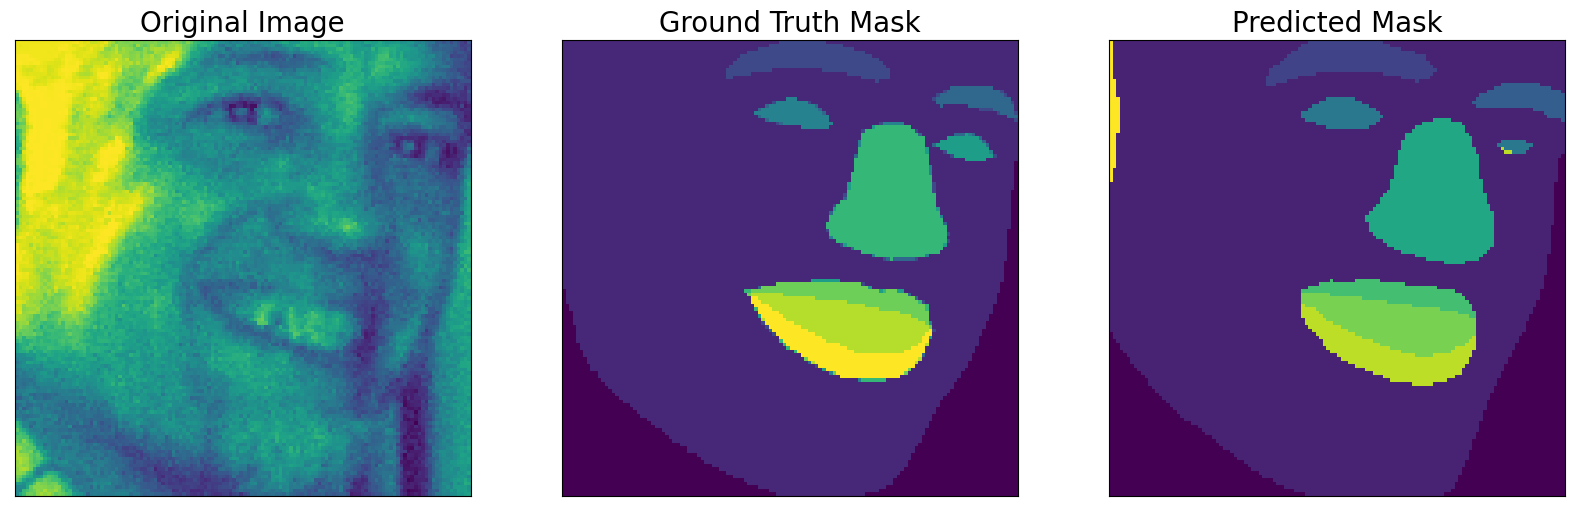

Dataset MIoU =  0.6051198724657297
Dataset F1 =  [0.8826418  0.9634733  0.6962351  0.7237428  0.6540205  0.21038766
 0.9371017  0.7836564  0.7145659  0.82488    0.7609927 ]
Dataset F1 av =  0.7410635


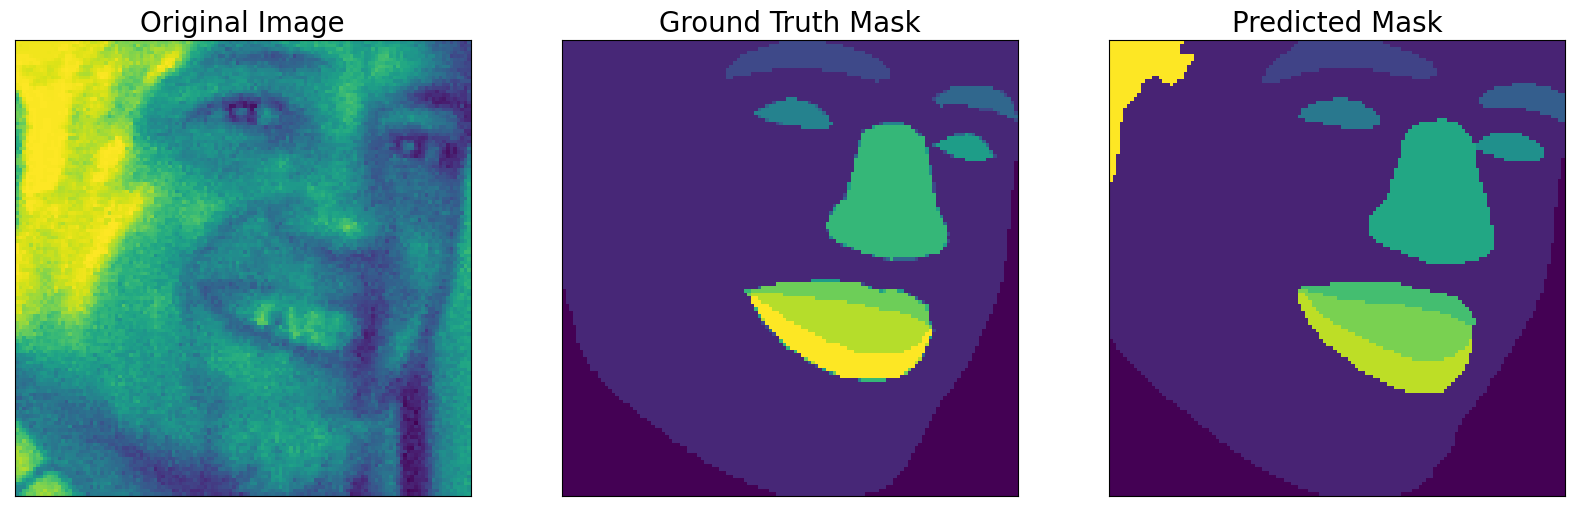

Dataset MIoU =  0.6590730309933424
Dataset F1 =  [0.8739103  0.9667412  0.70162493 0.7303724  0.7096229  0.71612984
 0.9412175  0.7945469  0.72743386 0.8285756  0.75521547]
Dataset F1 av =  0.79503554


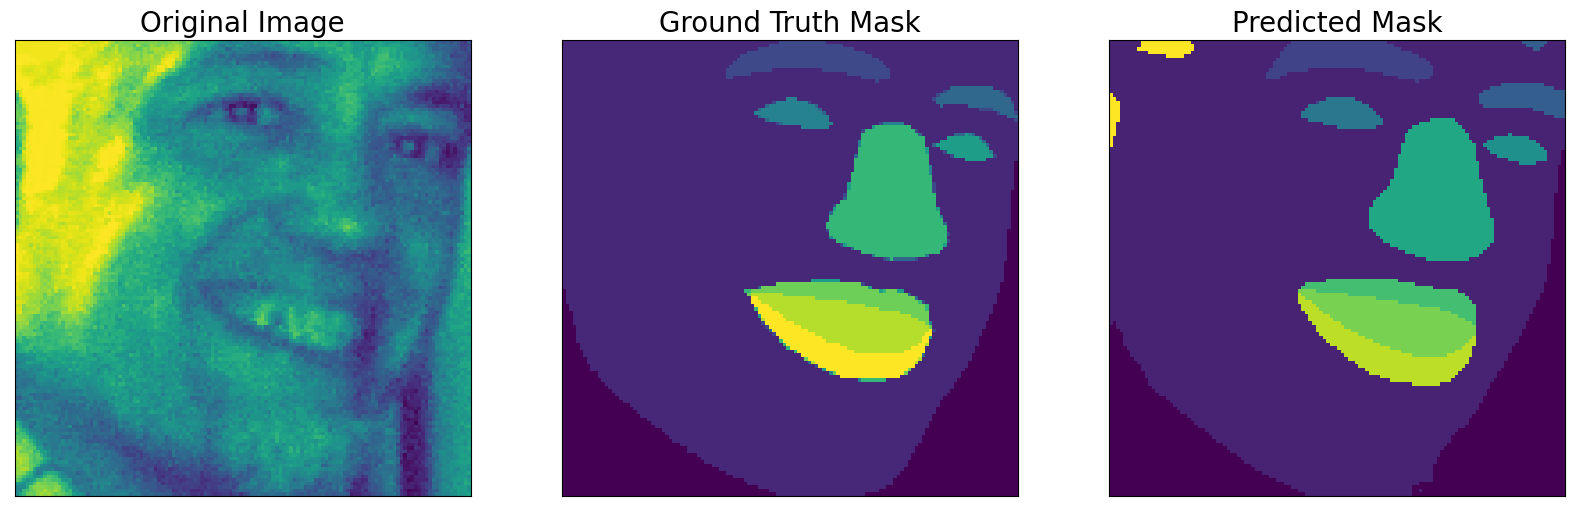

Dataset MIoU =  0.6633993600904942
Dataset F1 =  [0.87456375 0.9670517  0.7048435  0.72890544 0.7100753  0.71689147
 0.9415879  0.79502076 0.72669244 0.8362042  0.75889564]
Dataset F1 av =  0.79643023


In [20]:
print("LAPA:")

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)


# label adapter

In [92]:
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
save_predictions(model, test_ds)

/tmp/ipykernel_15278/107127779.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
/tmp/ipykernel_15278/107127779.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


saving 0 / 2000
saving 1 / 2000
saving 2 / 2000
saving 3 / 2000
saving 4 / 2000
saving 5 / 2000
saving 6 / 2000
saving 7 / 2000
saving 8 / 2000
saving 9 / 2000
saving 10 / 2000
saving 11 / 2000
saving 12 / 2000
saving 13 / 2000
saving 14 / 2000
saving 15 / 2000
saving 16 / 2000
saving 17 / 2000
saving 18 / 2000
saving 19 / 2000
saving 20 / 2000
saving 21 / 2000
saving 22 / 2000
saving 23 / 2000
saving 24 / 2000
saving 25 / 2000
saving 26 / 2000
saving 27 / 2000
saving 28 / 2000
saving 29 / 2000
saving 30 / 2000
saving 31 / 2000
saving 32 / 2000
saving 33 / 2000
saving 34 / 2000
saving 35 / 2000
saving 36 / 2000
saving 37 / 2000
saving 38 / 2000
saving 39 / 2000
saving 40 / 2000
saving 41 / 2000
saving 42 / 2000
saving 43 / 2000
saving 44 / 2000
saving 45 / 2000
saving 46 / 2000
saving 47 / 2000
saving 48 / 2000
saving 49 / 2000
saving 50 / 2000
saving 51 / 2000
saving 52 / 2000
saving 53 / 2000
saving 54 / 2000
saving 55 / 2000
saving 56 / 2000
saving 57 / 2000
saving 58 / 2000
saving 

## create our datasets

In [6]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re


class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None, training=True):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    if training == True:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][200::]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][200::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:200]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][:200]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    image = torch.tensor(image)

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).float()

    return (image.permute(2,0,1).float(), one_hot_Y.permute(2,0,1).float())


train_x_path = "/home/nathan/Documents/final_project/datasets/label_adapter/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/label_adapter/masks"

val_x_path = train_x_path
val_y_path = train_y_path

train_ds2 = MyDataSet(train_x_path, train_y_path, None, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation())
val_ds2 = MyDataSet(val_x_path, val_y_path, None, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation(), training=False)


### Data Loader

In [291]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader2 = DataLoader(train_ds2, batch_size=2, shuffle=True, num_workers=12)
valid_loader2 = DataLoader(val_ds2, batch_size=2, shuffle=False, num_workers=12)
print(len(train_loader2))

900


/home/nathan/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([3, 128, 128])
torch.Size([11, 128, 128])


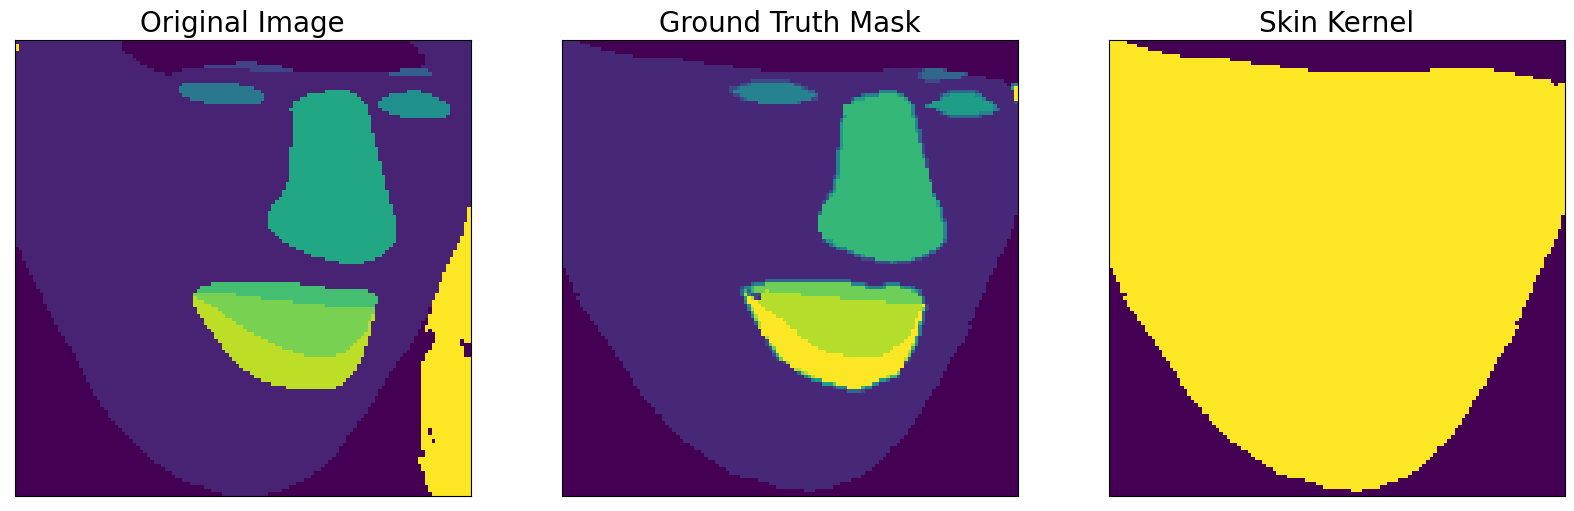

torch.Size([3, 128, 128])
torch.Size([11, 128, 128])


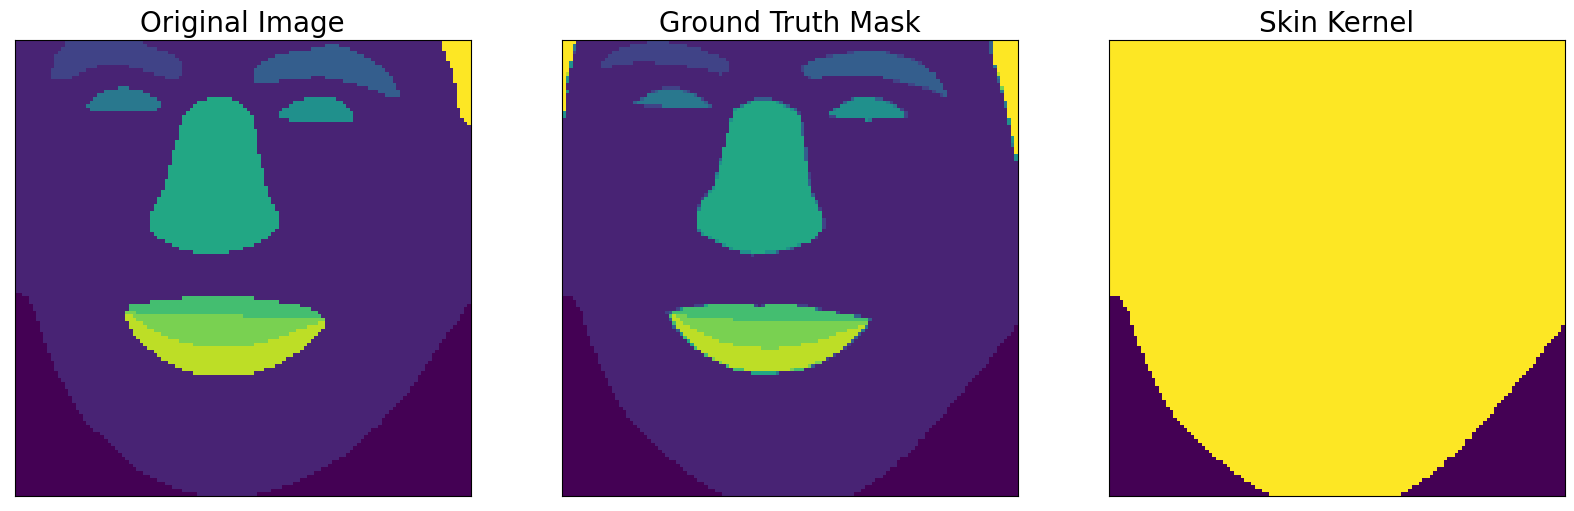

In [15]:
from PIL import ImageFilter
from scipy import ndimage
from collections import Counter


for x in range(2):

    image_vis = val_ds2[x][0]
    print(image_vis.shape)

    gt_mask = val_ds2[x][1]
    print(gt_mask.shape)

    reverse = reverse_one_hot(gt_mask)

    skin_kernel = np.ones((4,4))

    tmp = scipy.ndimage.convolve(np.array(reverse), skin_kernel, mode='constant')
    filter = np.array(np.logical_and(np.array(tmp) >= 1, reverse)).astype(np.float32)

    visualize(
        original_image = image_vis[0,::],
        ground_truth_mask = reverse,
        skin_kernel  = (filter),
    )

# custom FCN label adapter train

In [273]:
from torchvision.models.vgg import VGG
import torch.nn as nn

class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [274]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

In [275]:
from torch import optim

fcn = FCN8s(VGG16(cfg,ranges), num_classes)

criterion = nn.BCELoss()
optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(12, 3, 64, 64)
y = torch.randn(12, num_classes, 64, 64)
y = torch.tensor(y, requires_grad=False)

for i in range(3):
  optimizer.zero_grad()
  output = fcn(x)
  output = torch.sigmoid(output)
  loss = criterion(output, y)
  loss.backward()
  print("i: {}, loss: {:.5f}".format(i, loss.item()))
  optimizer.step()

/home/nathan/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/nathan/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:39<00:00, 14.0MB/s] 
/tmp/ipykernel_15278/3942448864.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

i: 0, loss: 0.76252
i: 1, loss: 0.76195
i: 2, loss: 0.76088


In [276]:
# Define model
n_classes = 11
model = FCN8s(VGG16(cfg, ranges), n_classes)
model.to("cuda")

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
epochs = 50
print_every = 20

# Define scores
IoU_scores = np.zeros((epochs, n_classes))
pixel_scores = np.zeros(epochs)

In [277]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, validloader, criterion):
  total_ious = []
  pixel_accs = []
  for i, batch in enumerate(validloader):
    inputs = batch['x'].to("cuda")
    output = model(inputs)
    output = output.data.cpu().numpy()
        
    N, _, h, w = output.shape 
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
    target = batch['l'].cpu().numpy().reshape(N, h, w)
    
    for y_hat, y in zip(pred, target):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  return pixel_acc, mean_iou

In [ ]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, valid_loader2, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

In [ ]:
best = 0
for epoch in range(epochs):
  for i, batch in enumerate(train_loader2):
    inputs, labels = batch['x'].to("cuda"), batch['y'].to("cuda")
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        paccuracy, meaniou = validation(model, valid_loader2, criterion)
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training loss: {:.5f}.. ".format(loss.item()),
              "Pixel accuracy.. {:.5f}".format(paccuracy),
              "Mean IU.. {:.5f}".format(meaniou))
      if best < meaniou:
        torch.save(model.state_dict(), "./fcn-model-meaniuo.pth")
        best = meaniou
      model.train()

In [293]:
label_adapter = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights="imagenet", 
    classes=11, 
    activation="sigmoid",
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)
#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Epoch: 1
valid: 100%|██████████| 100/100 [00:05<00:00, 16.71it/s, cross_entropy_loss - 0.8577, iou_score - 0.8099]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 2
valid: 100%|██████████| 100/100 [00:06<00:00, 14.97it/s, cross_entropy_loss - 0.857, iou_score - 0.8133]
Model saved!
Decrease decoder learning rate to 1e-5!


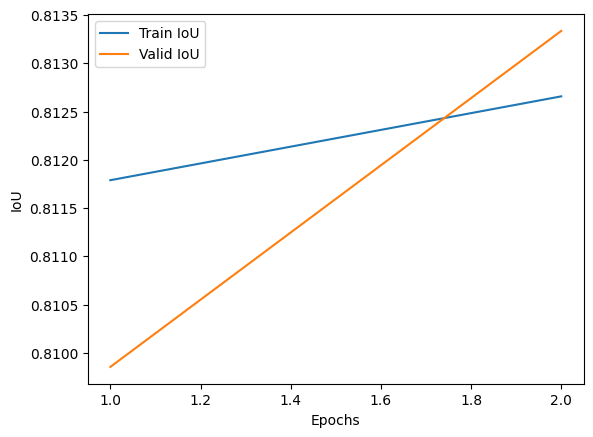


Epoch: 3
valid: 100%|██████████| 100/100 [00:06<00:00, 14.55it/s, cross_entropy_loss - 0.857, iou_score - 0.8121]
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s, cross_entropy_loss - 0.8569, iou_score - 0.8122]
Decrease decoder learning rate to 1e-5!


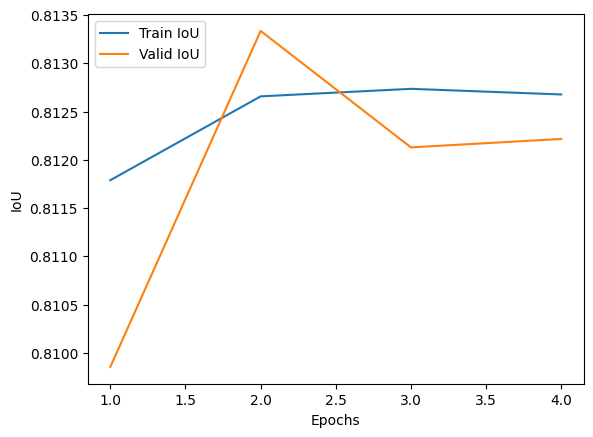


Epoch: 5
valid: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s, cross_entropy_loss - 0.8568, iou_score - 0.8126]
Decrease decoder learning rate to 1e-5!

Epoch: 6
valid: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s, cross_entropy_loss - 0.8568, iou_score - 0.8122]
Decrease decoder learning rate to 1e-5!


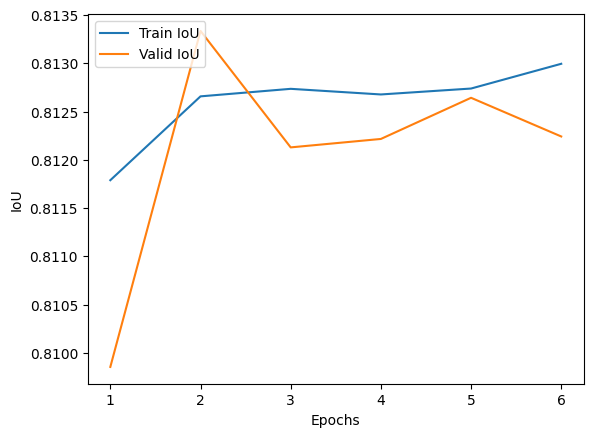


Epoch: 7
valid: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s, cross_entropy_loss - 0.8568, iou_score - 0.8125]
Decrease decoder learning rate to 1e-5!

Epoch: 8
valid: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s, cross_entropy_loss - 0.8567, iou_score - 0.8138]
Model saved!
Decrease decoder learning rate to 1e-5!


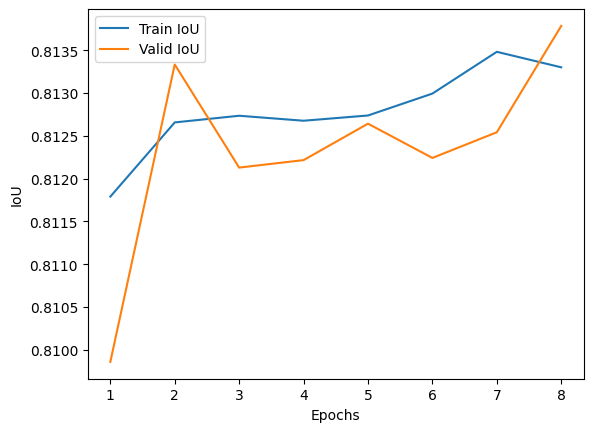


Epoch: 9
valid: 100%|██████████| 100/100 [00:05<00:00, 19.33it/s, cross_entropy_loss - 0.8567, iou_score - 0.8137]
Decrease decoder learning rate to 1e-5!

Epoch: 10
valid: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s, cross_entropy_loss - 0.8567, iou_score - 0.8123]
Decrease decoder learning rate to 1e-5!


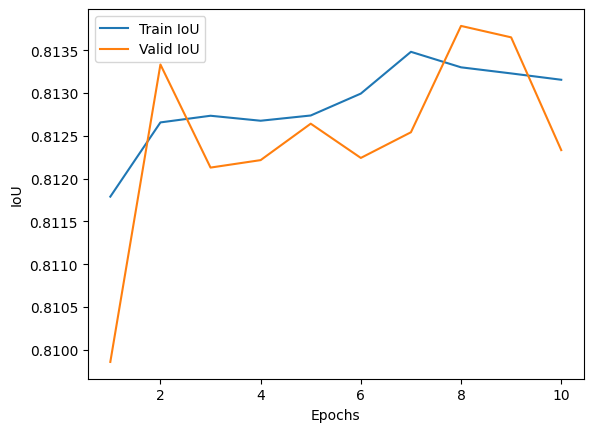


Epoch: 11
valid: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s, cross_entropy_loss - 0.8567, iou_score - 0.8128]
Decrease decoder learning rate to 1e-5!

Epoch: 12
valid:   0%|          | 0/100 [00:00<?, ?it/s]

In [301]:
train_model(label_adapter, train_loader2, valid_loader2, "/home/nathan/Documents/final_project/saved_models/lapa/label_adapted.pth", 20)

### Load and view model predictions

In [16]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image

def average(lst):
    return sum(lst) / len(lst)

def view_label_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image.cpu()
        image_vis = image.cpu()
        image_vis = np.transpose(image_vis,(1,2,0))
        print("vis:",image_vis.shape)
        print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        print("predraw", pred_mask.shape)
        print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        #gt_mask = scipy.signal.medfilt(gt_mask, 9)

        #Get f1
        #m = MultiLabelBinarizer().fit(gt_mask)
        #f1 = f1_score(m.transform(gt_mask), m.transform(pred_mask), average=None)
        #if len(f1) == num_classes:
        #  f1s.append(f1)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          print(f1)
          f1s.append(np.array(f1))

        try:
          if idx < 20:
            visualize(
                original_image = image[0,::],
                ground_truth_mask = gt_mask,
                predicted_mask = pred_mask,
            )
        except:
          if idx < 20:
            visualize(
                original_image = image.cuda()[0,::],
                ground_truth_mask = gt_mask.cuda(),
                predicted_mask = pred_mask.cuda(),
            )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.8988, 0.9563,    nan, 0.1139, 0.4965, 0.6387, 0.9540, 0.8170, 0.9120,
        0.8564,    nan])


/tmp/ipykernel_47277/100453050.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
/tmp/ipykernel_47277/100453050.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


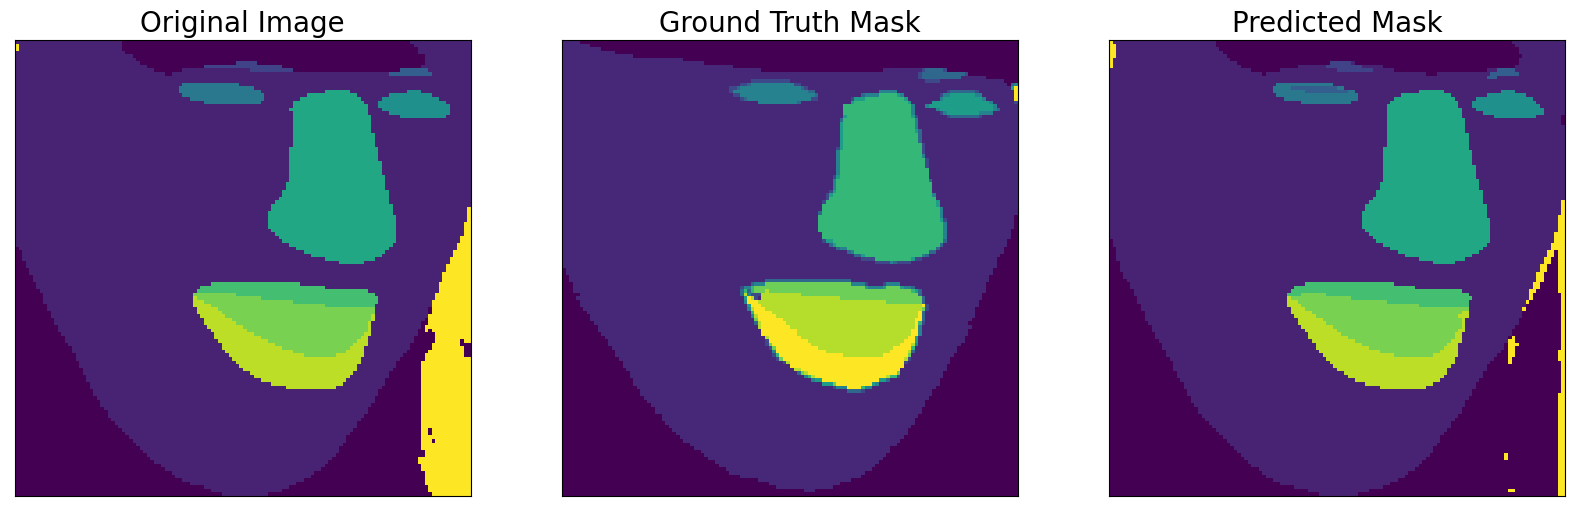

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9404, 0.9692, 0.7146, 0.7667, 0.4762, 0.7184, 0.9602, 0.5721, 0.8450,
        0.8610, 0.8114])


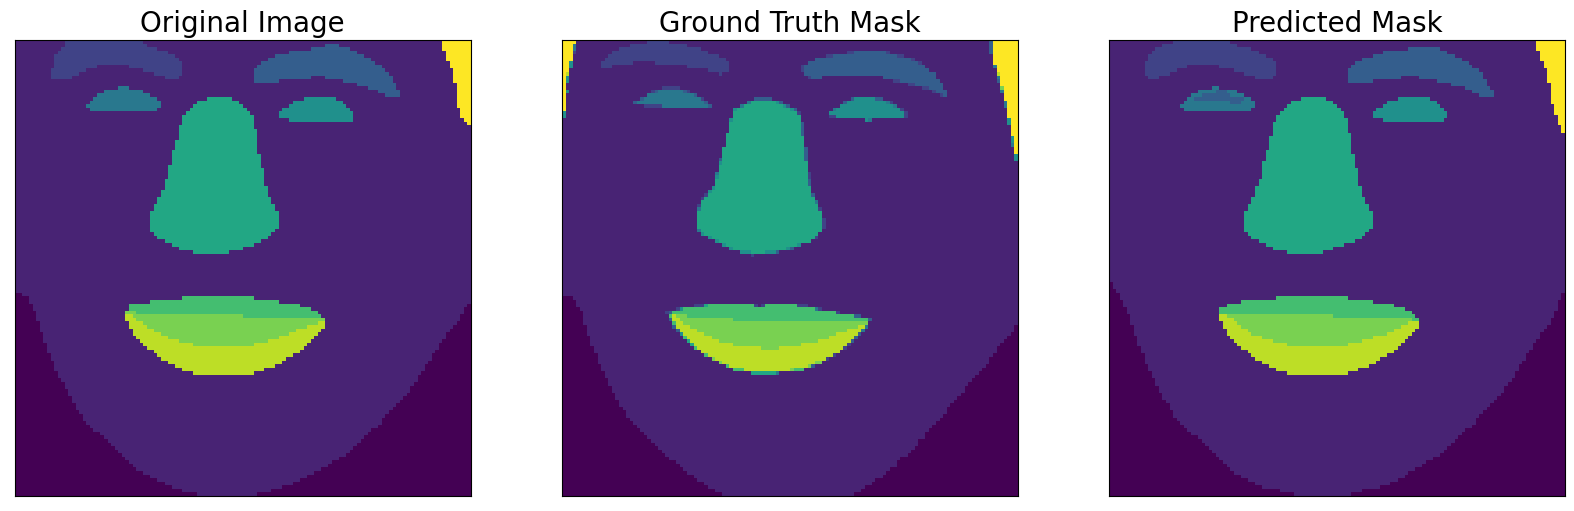

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9575, 0.9773,    nan,    nan, 0.6574, 0.7832, 0.9504, 0.7900, 0.2118,
        0.9078, 0.9104])


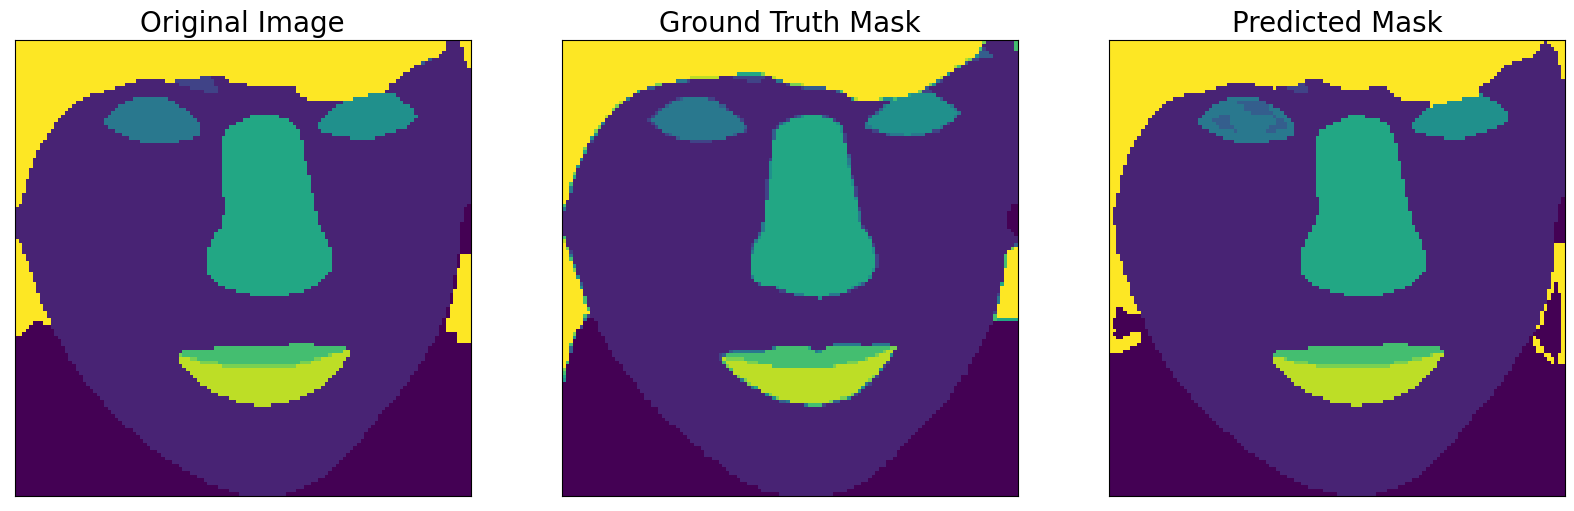

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9516, 0.9731, 0.7154, 0.8117, 0.6056, 0.5405, 0.9621, 0.8349, 0.9677,
        0.8502, 0.6154])


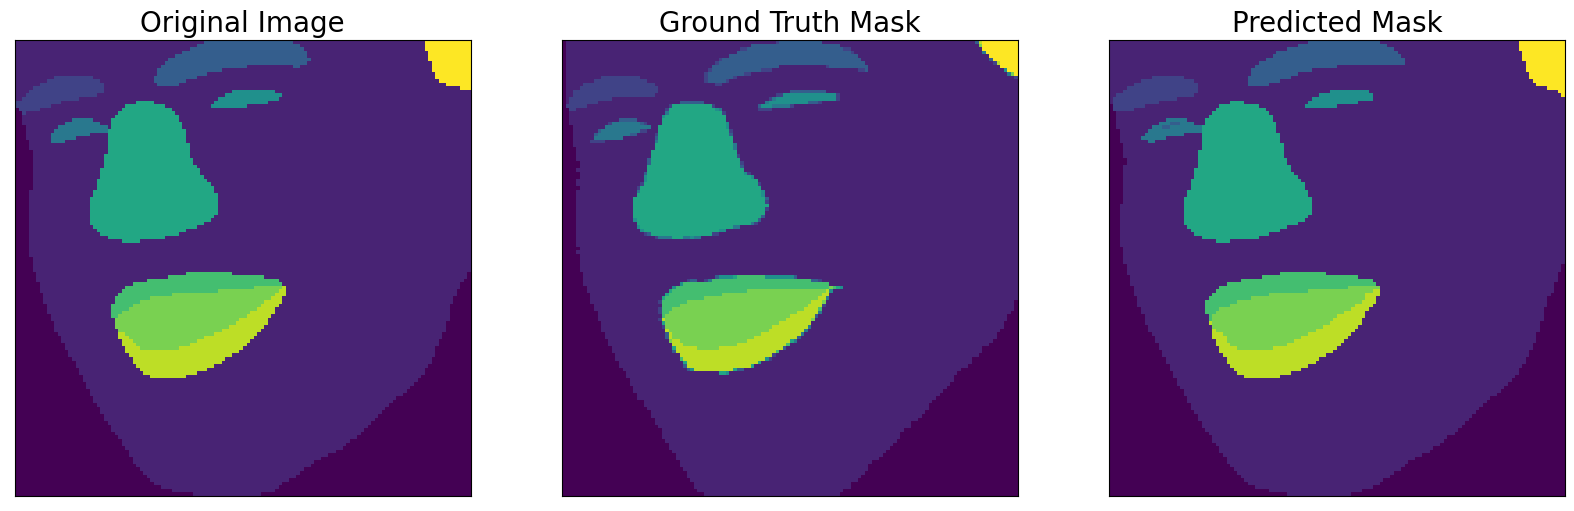

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.7499, 0.9465, 0.6852, 0.8148, 0.6784, 0.6449, 0.9529, 0.7490, 0.8126,
        0.8644, 0.3609])


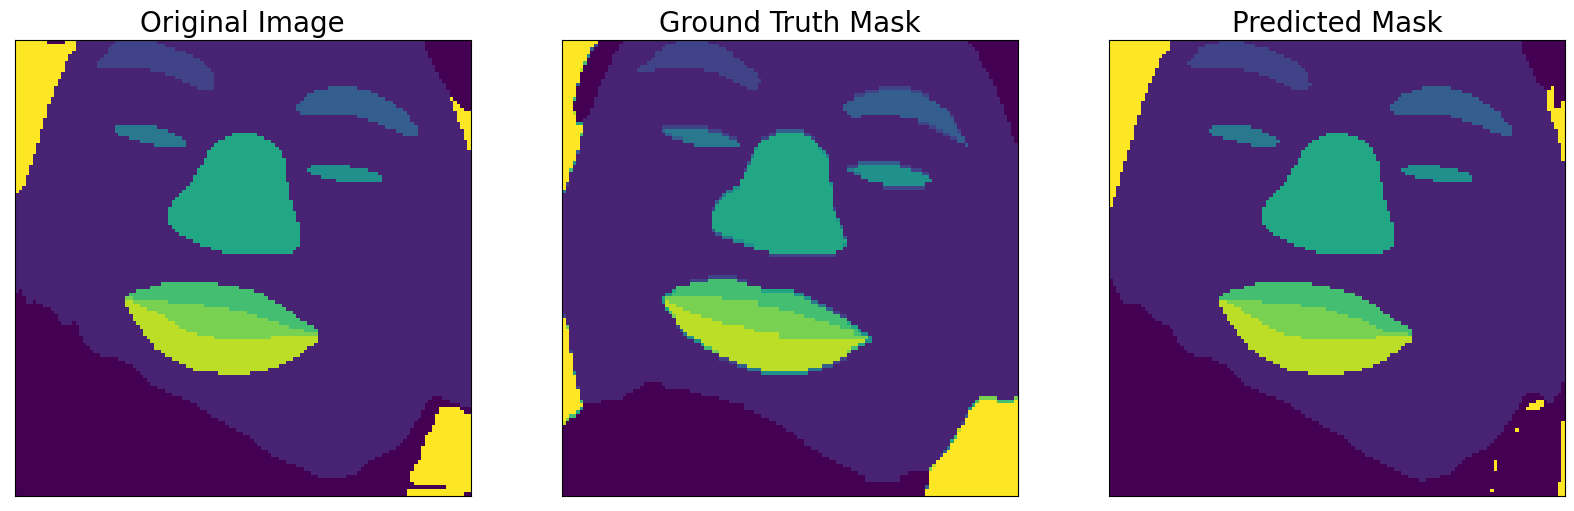

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9119, 0.9804, 0.7083, 0.7465, 0.6018, 0.8011, 0.9567, 0.7786, 0.1176,
        0.8401, 0.8753])


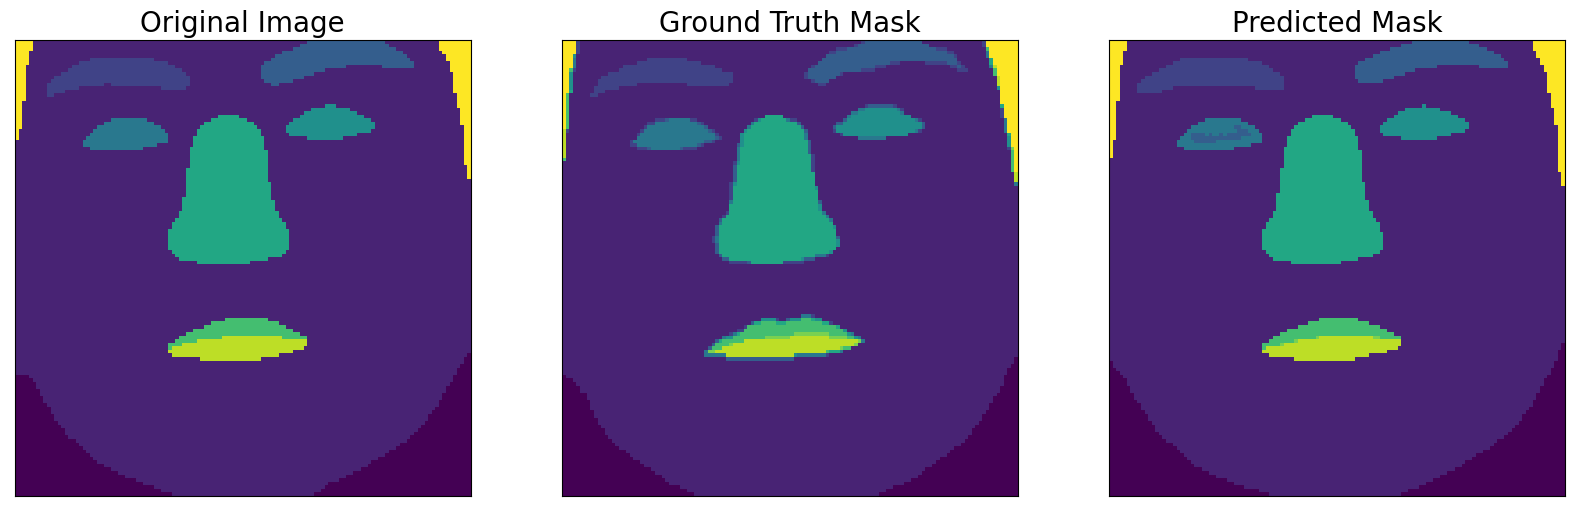

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9674, 0.9742, 0.6567, 0.7629, 0.4718, 0.7434, 0.9597, 0.8874, 0.2000,
        0.8653, 0.8747])


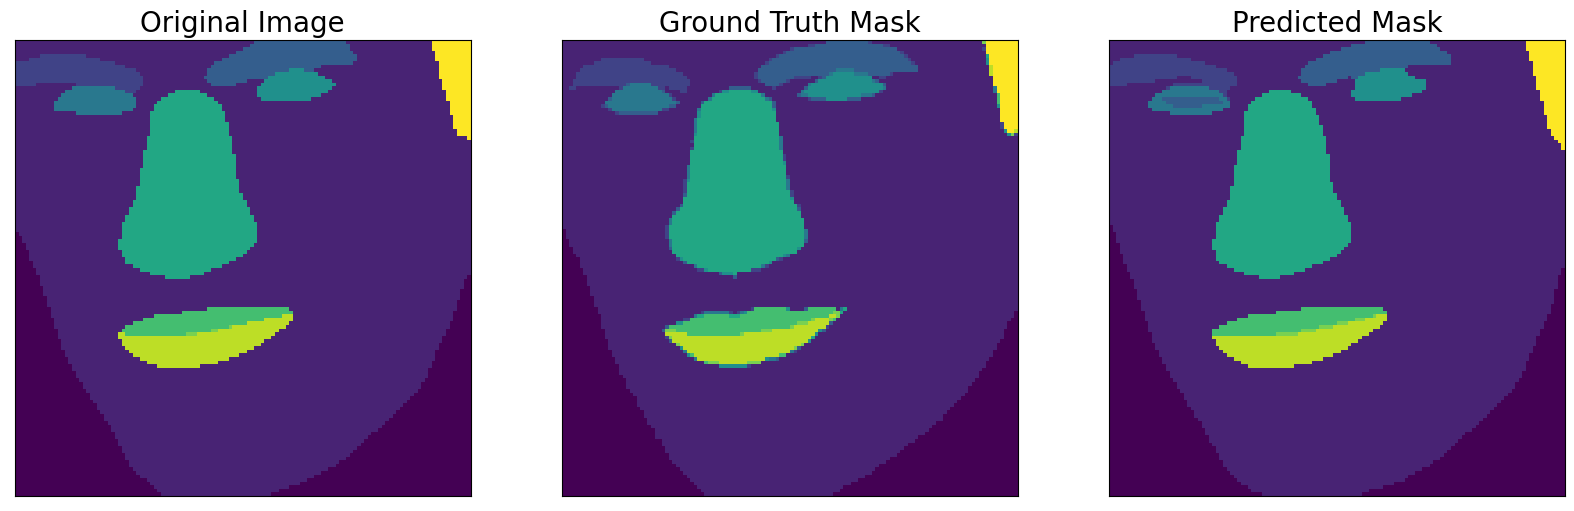

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9610, 0.9769, 0.6667, 0.7684, 0.5674, 0.8497, 0.9305, 0.8540, 0.9323,
        0.8346, 0.9032])


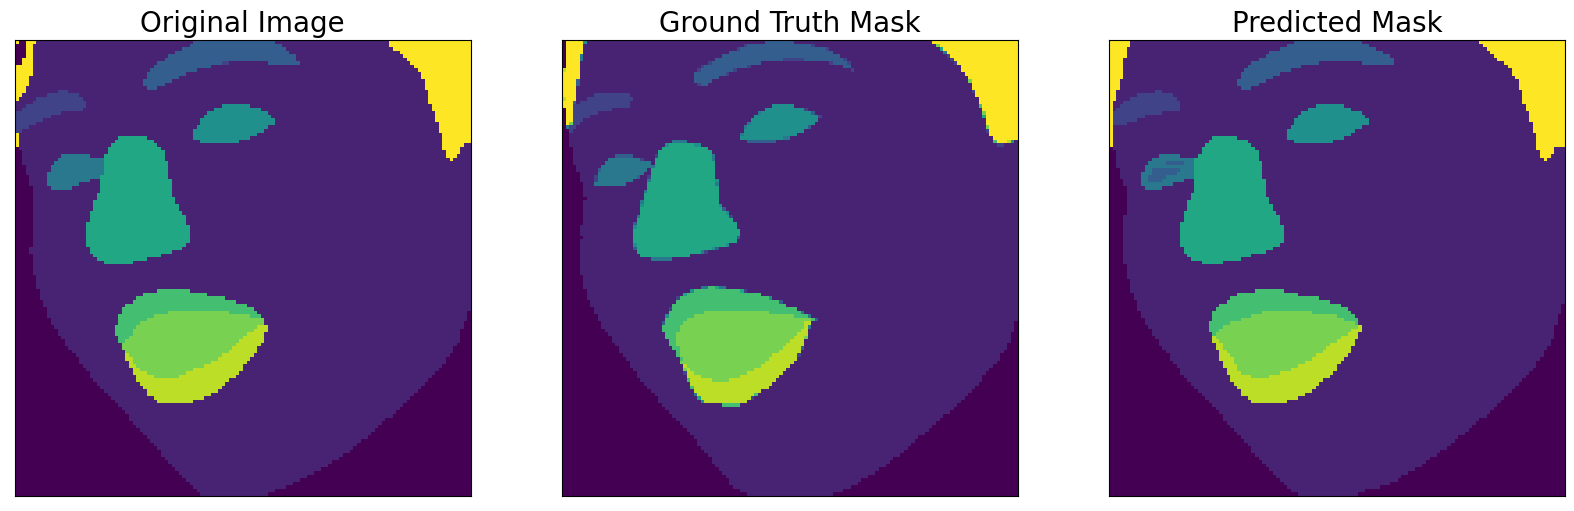

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9788, 0.9754, 0.8227, 0.5185, 0.5377, 0.5882, 0.9473, 0.7717, 0.1818,
        0.9128, 0.9028])


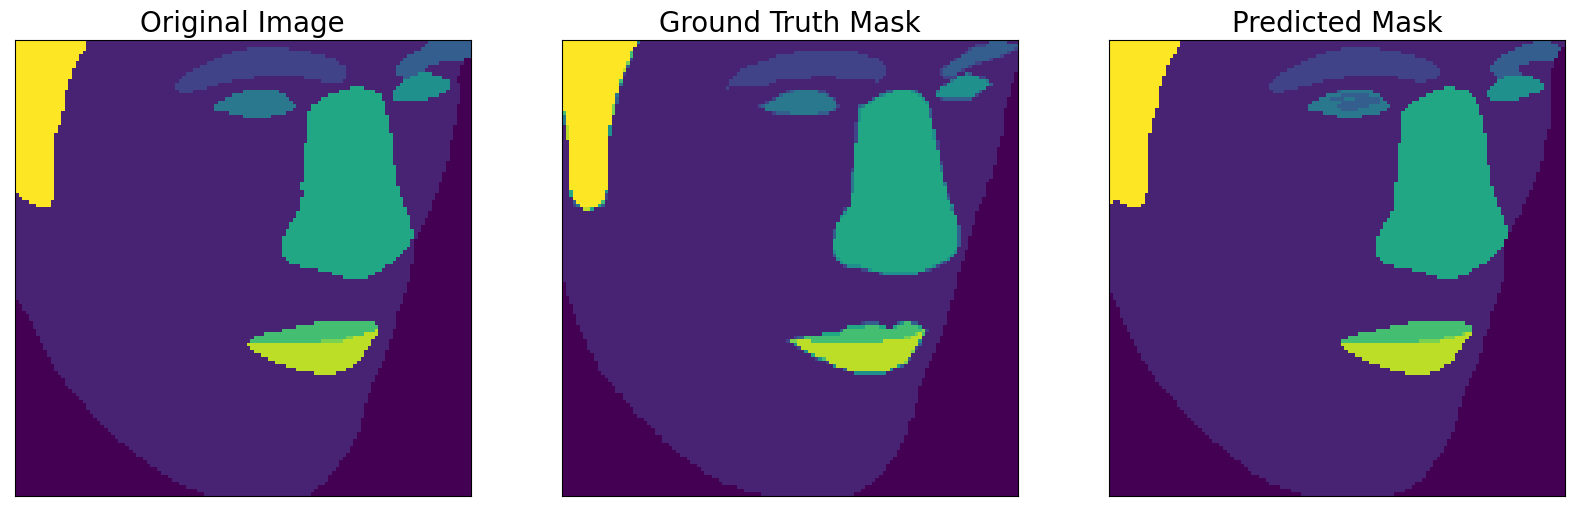

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9805, 0.9835, 0.8686, 0.8571, 0.7018, 0.8535, 0.9655, 0.8096, 0.8850,
        0.9023, 0.8278])


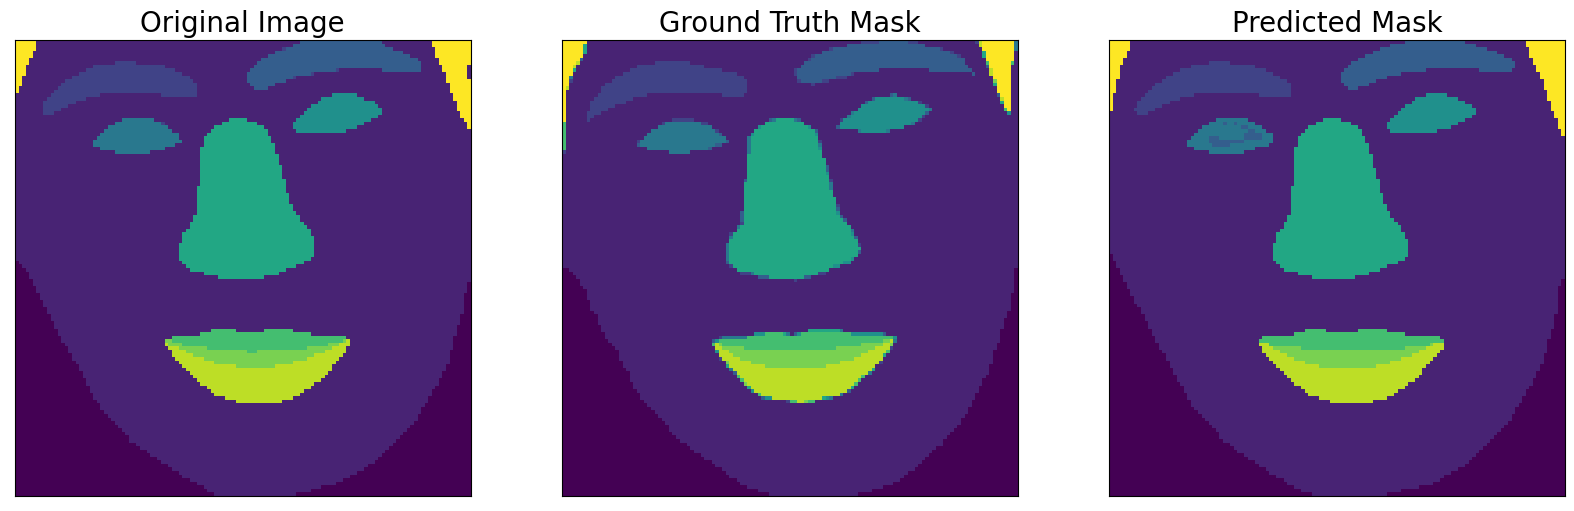

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.8459, 0.9436, 0.6524, 0.8544, 0.5191, 0.7818, 0.9606, 0.7812, 0.6761,
        0.8499, 0.7989])


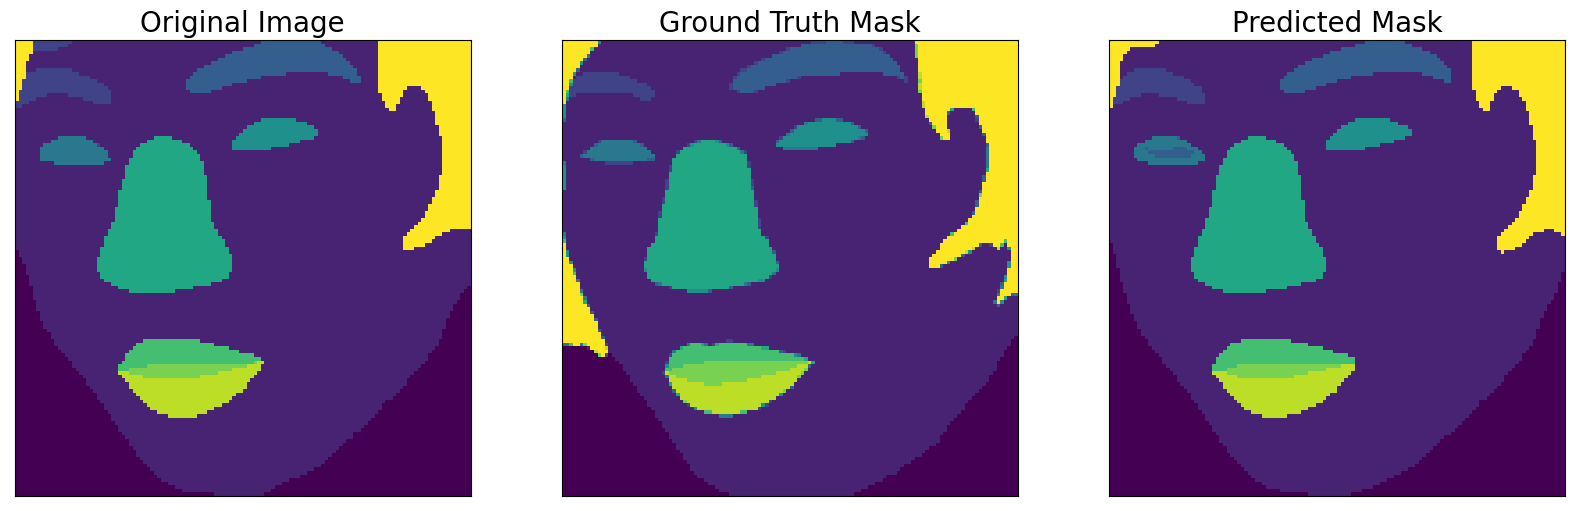

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.8873, 0.9654, 0.7950, 0.7435, 0.6667, 0.8144, 0.9527, 0.8427, 0.7897,
        0.8029, 0.5535])


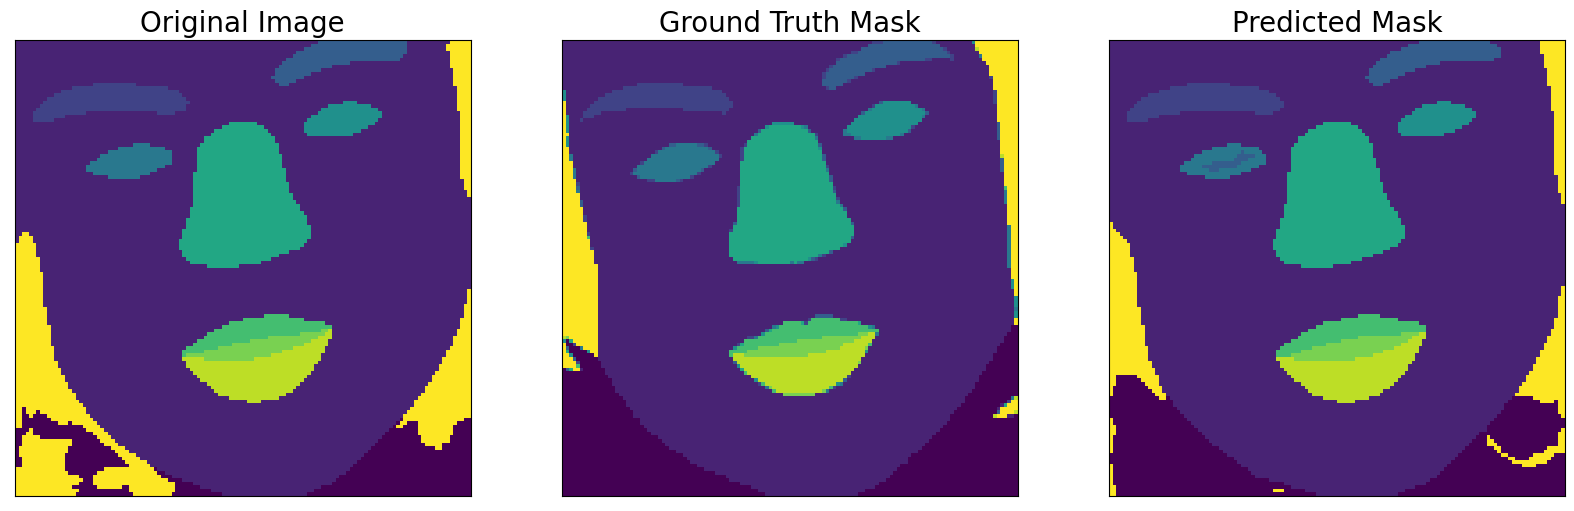

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9803, 0.9758, 0.7459, 0.6922, 0.3861, 0.6466, 0.9397, 0.7212, 0.4211,
        0.7366,    nan])


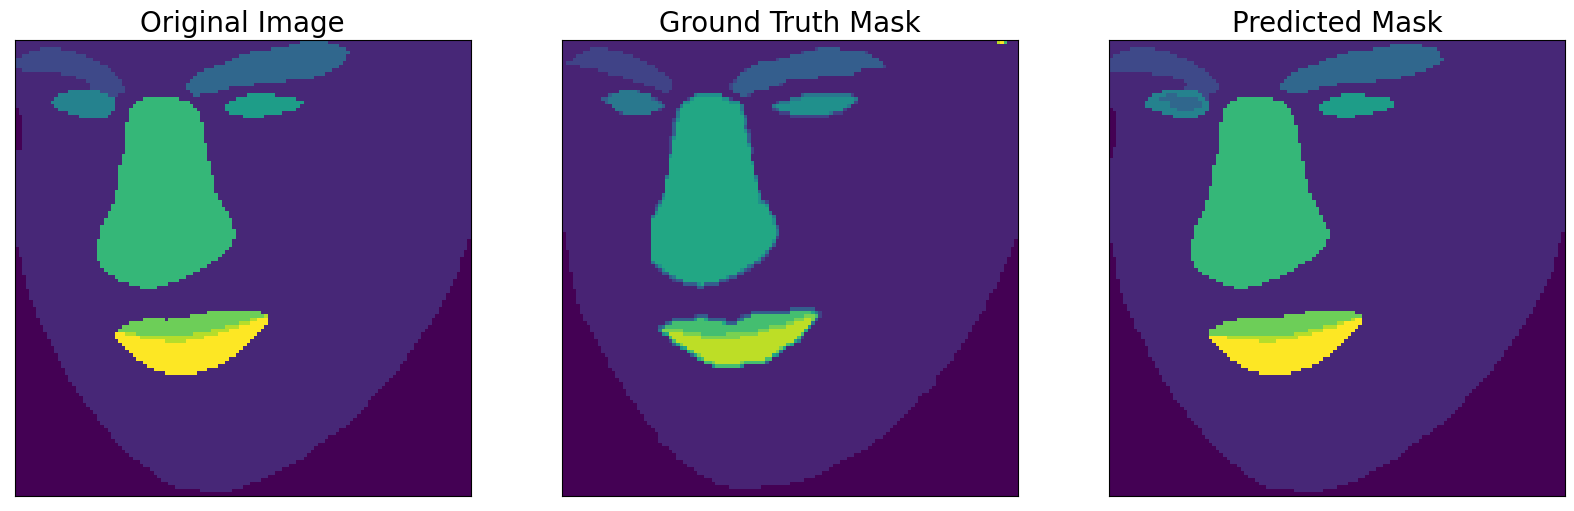

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9070, 0.9652, 0.9091, 0.8727, 0.7263, 0.8512, 0.9553, 0.7701, 0.9596,
        0.8627, 0.8019])


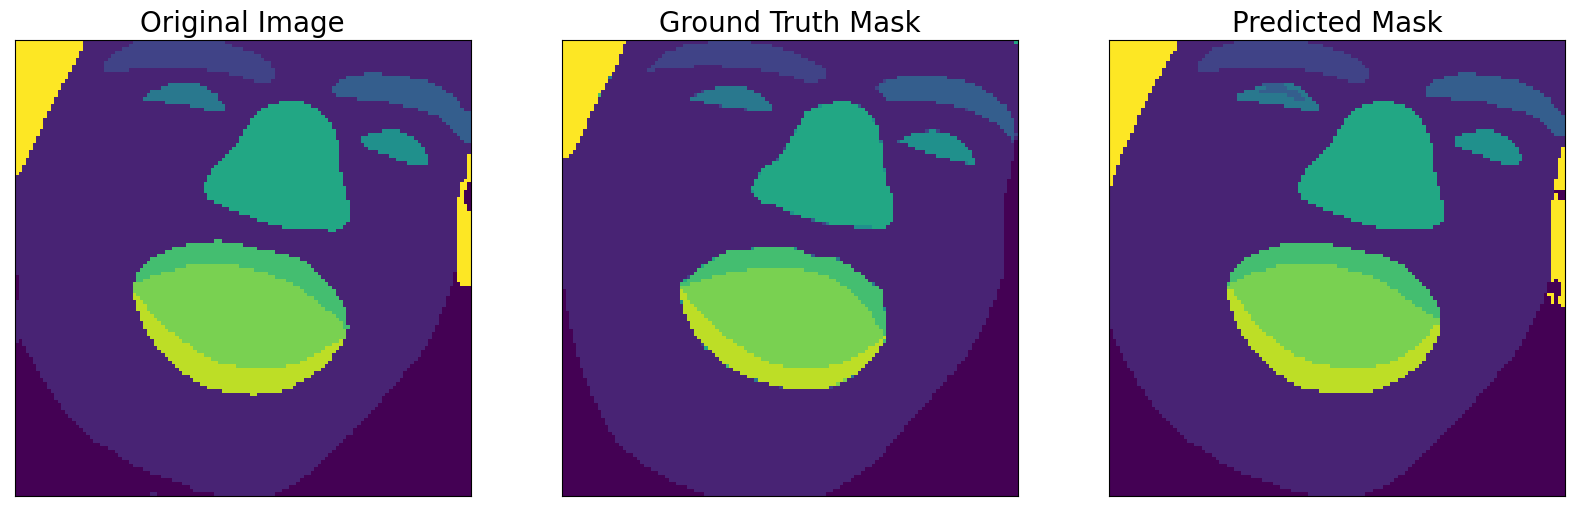

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9123, 0.9763, 0.6635, 0.6390, 0.5545, 0.7202, 0.9456, 0.7723, 0.8561,
        0.8039, 0.6495])


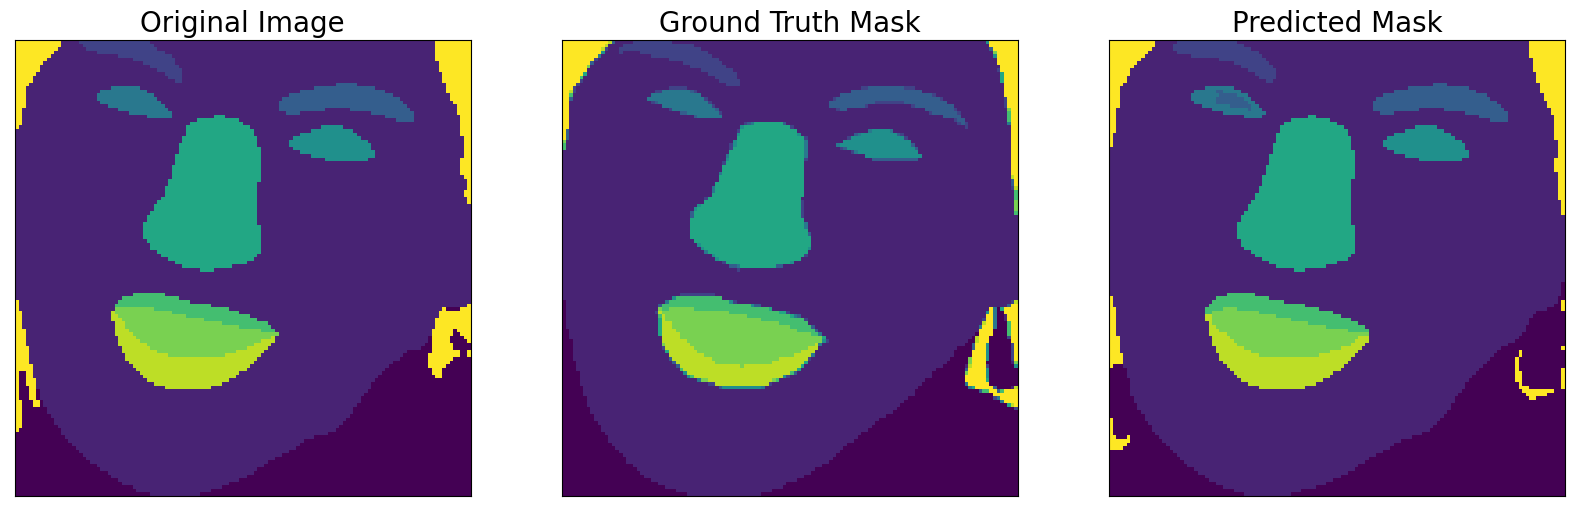

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.6979, 0.9235, 0.6817, 0.6864, 0.4774, 0.5820, 0.9518, 0.6942, 0.5371,
        0.8289, 0.6280])


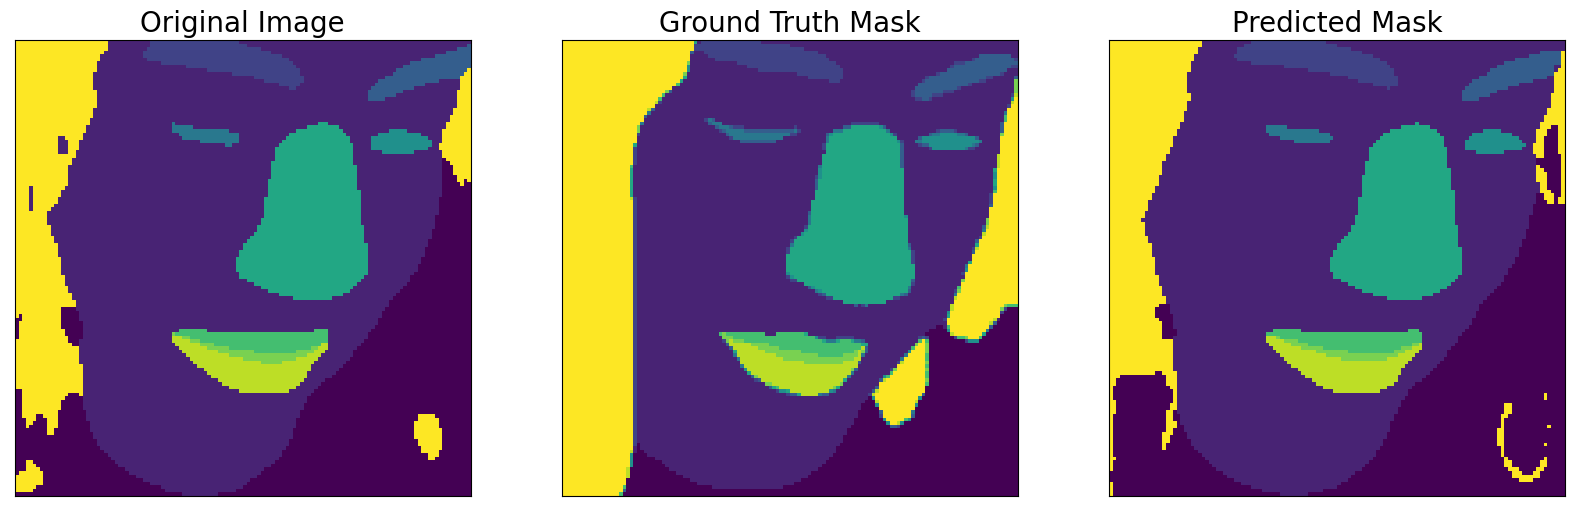

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9432, 0.9547, 0.7544, 0.8144, 0.6275, 0.7962, 0.9448, 0.8494, 0.2400,
        0.7028, 0.6870])


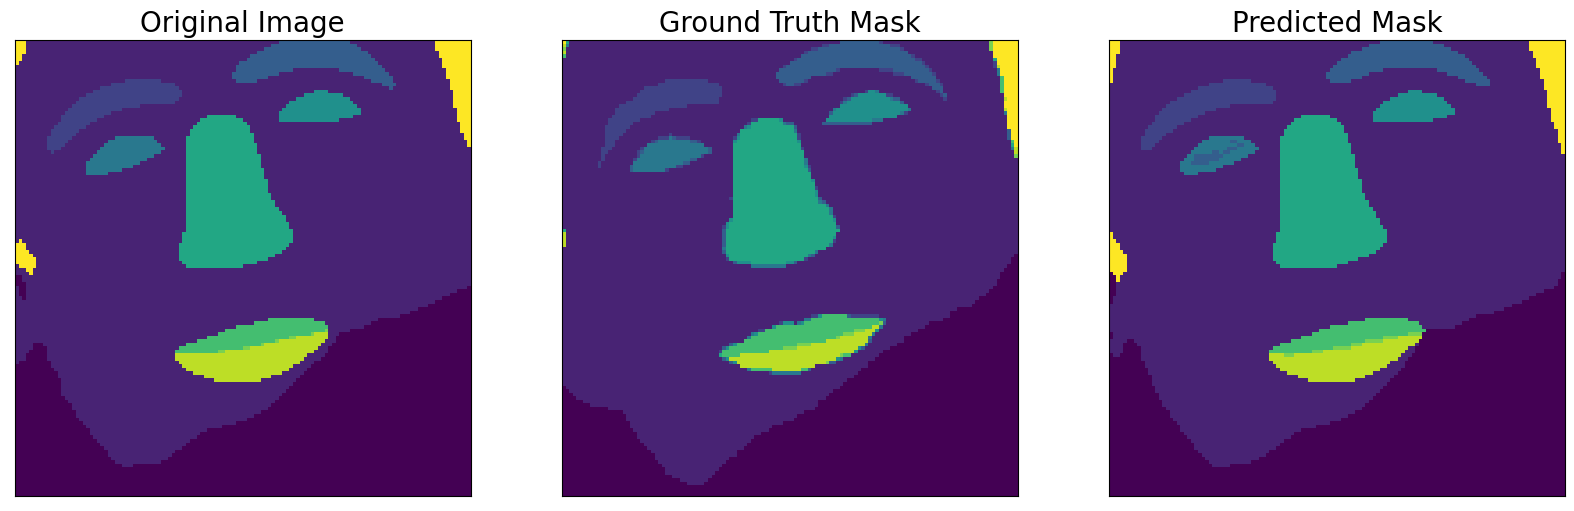

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.8845, 0.9750, 0.7651, 0.7327, 0.7653, 0.8208, 0.9512, 0.5777, 0.5879,
        0.8484,    nan])


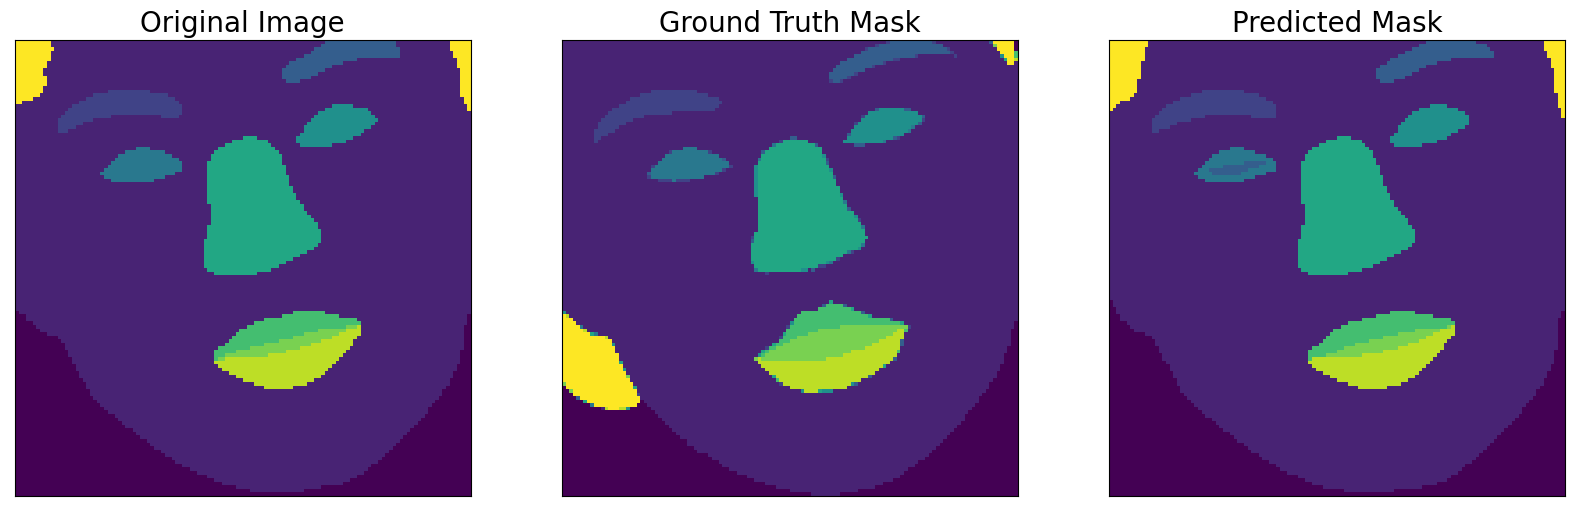

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.7435, 0.9740, 0.8554, 0.8320, 0.5622, 0.8050, 0.9656, 0.9113, 0.9492,
        0.9015, 0.4133])


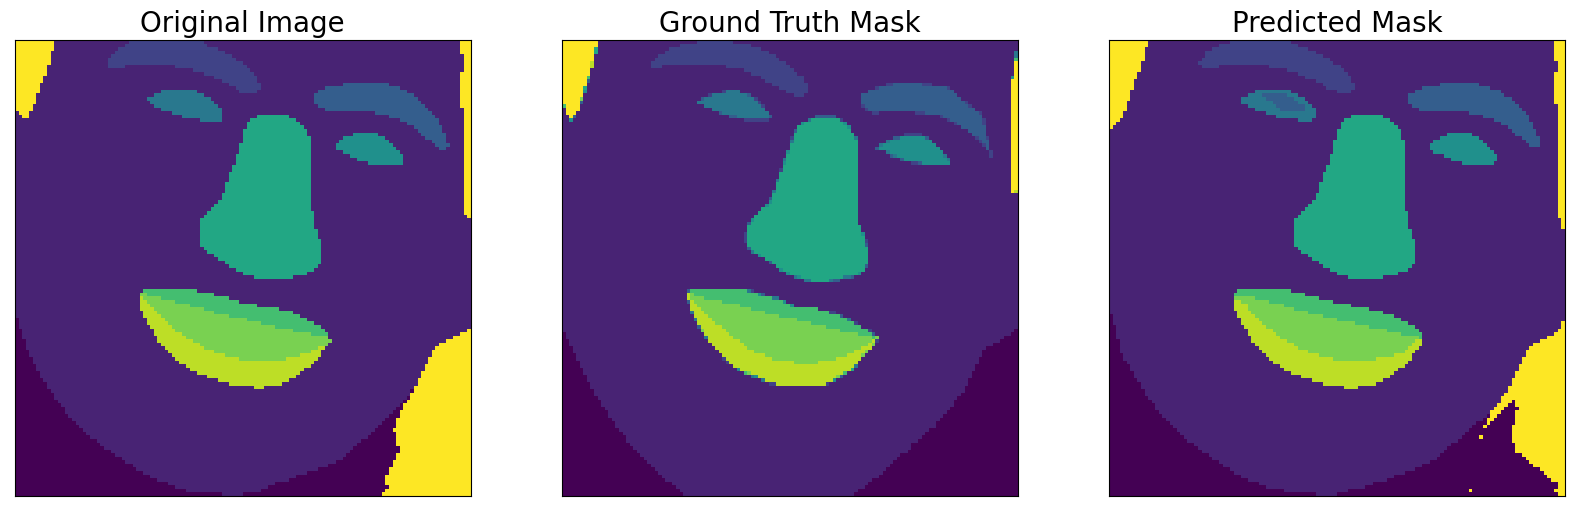

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.7901, 0.9374, 0.7333, 0.5836, 0.5263, 0.7577, 0.9394, 0.7532, 0.8739,
        0.8409, 0.5815])


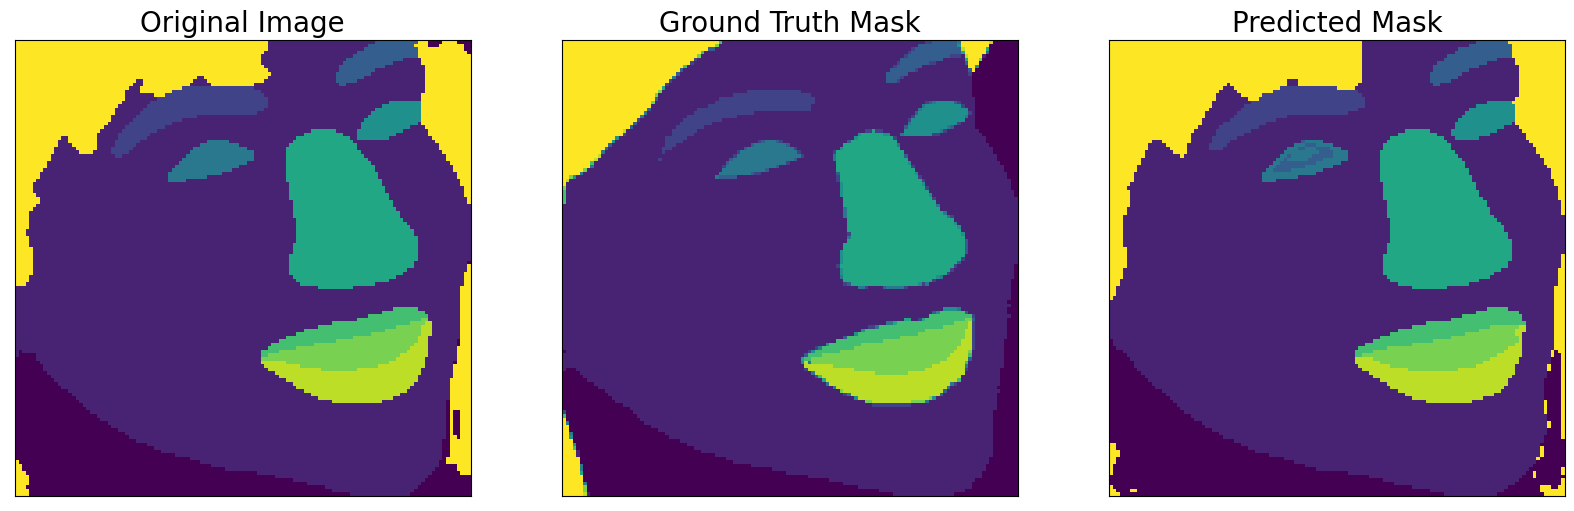

vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.1314, 0.9826, 0.7003, 0.7683, 0.4939, 0.6160, 0.9556, 0.8060, 0.5568,
        0.8889, 0.7193])
vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9322, 0.9839, 0.8204, 0.8084, 0.7138, 0.6943, 0.9632, 0.8915, 0.2647,
        0.9333, 0.6454])
vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128])
(11, 128, 128)
(128, 128)
torch.Size([11, 128, 128])
tensor([0.9444, 0.9767, 0.6446, 0.8019, 0.4375, 0.7464, 0.9719, 0.7577, 0.8493,
        0.8696, 0.9622])
vis: torch.Size([128, 128, 3])
im: torch.Size([3, 128, 128])
predraw torch.Size([1, 11, 128, 128])
gtraw torch.Size([11, 128, 128]

In [17]:
DEVICE = "cuda"
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/label_adapted.pth", map_location="cuda")

view_label_predictions(model,val_ds2, num_classes)